In [47]:
#Trabajo final
#Nombre: Juan Esteban Bolívar Torres

In [48]:
# Importar los modulos que vamos a usar

import scipy.stats as ss          # modulo de estadistica
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import kpss
from scipy.stats import ks_2samp
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.stats.weightstats import ztest as ztest
import scipy as scp
import pywt

In [49]:
!pip install pymannkendall

import pymannkendall as mk

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:

def pruebaf(varianza1,varianza2,n1,n2):

   # Estadístico F
  if(varianza1>varianza2):
    F = varianza1 / varianza2
  elif(varianza1<varianza2):
    F = varianza2 / varianza1
  elif(varianza1==varianza2):
    F = 1
    print("dió 1")

  # Grados de libertad
  df1 = n1 - 1
  df2 = n2 - 1

  # Valor crítico dos colas
  alpha = 0.05
  F_critical = ss.f.ppf(1 - alpha/2, df1, df2)

  # Valor P de la prueba F

  p_value = 2 * min(ss.f.cdf(F, df1, df2), 1 - ss.f.cdf(F, df1, df2))


  return F, p_value

In [52]:

# define direccion para leer archivos
path_in = "/content/drive/MyDrive/ANALISIS DE DATOS/Trabajo final/"

# lee los datos
data_f = pd.read_csv(path_in + 'Siata_38_AD.csv')
data_fo3 = data_f.copy()

# Filtrado de calidad de datos para pm25 y ozono
data_f = data_f[data_f['calidad_pm25'].isin([1, -1])]
data_fo3 = data_fo3[data_fo3['calidad_ozono'].isin([1, -1, 1.8, 1.9])]

# Organizando indexado de fechas
dates_f = data_f['Fecha_Hora'].values
data_f['Fecha_Hora'] = pd.to_datetime(data_f['Fecha_Hora'])
data_f.sort_values('Fecha_Hora', inplace=True)
data_f.set_index('Fecha_Hora', inplace=True)

dates_fo3 = data_fo3['Fecha_Hora'].values
data_fo3['Fecha_Hora'] = pd.to_datetime(data_fo3['Fecha_Hora'])
data_fo3.sort_values('Fecha_Hora', inplace=True)
data_fo3.set_index('Fecha_Hora', inplace=True)

# Usamos este filtro debido a que hay un hueco muy grande en los datos ozono despúes de esta fecha
data_f = data_f[data_f.index < '2024-08-15 10:00:00']
data_fo3 = data_fo3[data_fo3.index < '2024-08-15 10:00:00']

data_full = data_f[['pm25']].join(data_fo3[['ozono']], how='outer')

# Interpolamos datos para poder llenar algunos huecos
data_full['pm25'] = data_full['pm25'].interpolate(method='time')
data_full['ozono'] = data_full['ozono'].interpolate(method='time')

# Obtenemos los valores de pm25 y ozono

pm25 = data_full['pm25'].values
ozono = data_full['ozono'].values



In [53]:
print(f"Número original de puntos PM25: {len(pm25)}")
print(f"Número original de puntos Ozono: {len(ozono)}")

# Calculo de la media y la desviación estándar
mean_pm25 = np.mean(pm25)
std_pm25 = np.std(pm25)

# Límites para 3 desviaciones estándar
lower_limit = mean_pm25 - 3 * std_pm25
upper_limit = mean_pm25 + 3 * std_pm25

# Filtración de los datos para eliminar los valores fuera de los límites
pm25 = pm25[(pm25 >= lower_limit) & (pm25 <= upper_limit)]

# Lo mismo pero para ozono
mean_ozono = np.mean(ozono)
std_ozono = np.std(ozono)
lower_limit_o3 = mean_ozono - 3 * std_ozono
upper_limit_o3 = mean_ozono + 3 * std_ozono
ozono = ozono[(ozono >= lower_limit_o3) & (ozono <= upper_limit_o3)]

# Actualizando el dataframe original
data_full['pm25'] = data_full['pm25'][(data_full['pm25'] >= lower_limit) & (data_full['pm25'] <= upper_limit)]
data_full['ozono'] = data_full['ozono'][(data_full['ozono'] >= lower_limit_o3) & (data_full['ozono'] <= upper_limit_o3)]

# Para ver la diferencia en el número de puntos
print(f"Número de puntos PM25 después de filtrar: {len(pm25)}")
print(f"Número de puntos Ozono después de filtrar: {len(ozono)}")

Número original de puntos PM25: 11825
Número original de puntos Ozono: 11825
Número de puntos PM25 después de filtrar: 11718
Número de puntos Ozono después de filtrar: 11707


In [54]:
# Resumen estadistico de PM25

# Estadisticas
stats_sf = ss.describe(pm25)
nobs=stats_sf[0]
minv,maxv=stats_sf[1]
media_varf=stats_sf[2]
variance_varf=stats_sf[3]
skewness=stats_sf[4]
kurtosis=stats_sf[5]
desv_estandar = np.sqrt(variance_varf)
mediana = np.median(pm25)

cv = (desv_estandar/media_varf)*100

# Percentiles
cuartiles = np.quantile(pm25, [0.25,0.5,0.75])
pos_q1 = 0.25*nobs
pos_q2 = 0.5*nobs
pos_q3 = 0.75*nobs
q1=cuartiles[0]
q2=cuartiles[1]
q3=cuartiles[2]
desvestandar_tads1 = np.sqrt(variance_varf)


# Resumen de datos
print("\nResumen estadístico de PM 2.5:")
print("Los cuartiles son:")
print("Q1:",q1,"[μg/m3] en la posición:",pos_q1)
print("Q2:",q2,"[μg/m3] en la posición:",pos_q2)
print("Q3:",q3,"[μg/m3] en la posición:",pos_q3)
print("---------------------------------------------------")
print("Las medidas estadisticas son:")
print("Número de observaciones:",nobs)
print("Mínimo:",minv,"[μg/m3]")
print("Máximo:",maxv,"[μg/m3]")
print("Media:",media_varf,"[μg/m3]")
print("Mediana:",mediana, "[μg/m3]")
print("Varianza:",variance_varf, "[μg/m3]^2")
print("Desviación estandar:",desv_estandar, "[μg/m3]")
print("Asimetria:", skewness)
print("Curtosis:", kurtosis)
print("Coeficiente de Variación (CV):", cv)



Resumen estadístico de PM 2.5:
Los cuartiles son:
Q1: 11.0 [μg/m3] en la posición: 2929.5
Q2: 15.0 [μg/m3] en la posición: 5859.0
Q3: 21.0 [μg/m3] en la posición: 8788.5
---------------------------------------------------
Las medidas estadisticas son:
Número de observaciones: 11718
Mínimo: 1.0 [μg/m3]
Máximo: 41.0 [μg/m3]
Media: 16.40758022537175 [μg/m3]
Mediana: 15.0 [μg/m3]
Varianza: 60.444528442721 [μg/m3]^2
Desviación estandar: 7.7746079285531176 [μg/m3]
Asimetria: 0.6947436328805842
Curtosis: 0.17825168583644935
Coeficiente de Variación (CV): 47.38424448798919


In [55]:
# Resumen estadistico de Ozono

#Estadisticas
stats_so3 = ss.describe(ozono)
nobs_o3 = stats_so3[0]
minv_o3, maxv_o3 = stats_so3[1]
media_varo3 = stats_so3[2]
variance_varo3 = stats_so3[3]
skewness_o3 = stats_so3[4]
kurtosis_o3 = stats_so3[5]
desv_estandar_o3 = np.sqrt(variance_varo3)
mediana_o3 = np.median(ozono)

cv_o3 = (desv_estandar_o3 / media_varo3) * 100

# Percentiles
cuartiles_o3 = np.quantile(ozono, [0.25, 0.5, 0.75])
pos_q1_o3 = 0.25 * nobs_o3
pos_q2_o3 = 0.5 * nobs_o3
pos_q3_o3 = 0.75 * nobs_o3
q1_o3 = cuartiles_o3[0]
q2_o3 = cuartiles_o3[1]
q3_o3 = cuartiles_o3[2]
desvestandar_tads1_o3 = np.sqrt(variance_varo3)

# Resumen de datos

print("\nResumen estadístico de Ozono:")
print("Los cuartiles son:")
print("Q1:", q1_o3, "[µg/m³] en la posición:", pos_q1_o3)
print("Q2:", q2_o3, "[µg/m³] en la posición:", pos_q2_o3)
print("Q3:", q3_o3, "[µg/m³] en la posición:", pos_q3_o3)
print("---------------------------------------------------")
print("Las medidas estadísticas son:")
print("Número de observaciones:", nobs_o3)
print("Mínimo:", minv_o3, "[µg/m³]")
print("Máximo:", maxv_o3, "[µg/m³]")
print("Media:", media_varo3, "[µg/m³]")
print("Mediana:", mediana_o3, "[µg/m³]")
print("Varianza:", variance_varo3, "[µg/m³]^2")
print("Desviación estándar:", desv_estandar_o3, "[µg/m³]")
print("Asimetría:", skewness_o3)
print("Curtosis:", kurtosis_o3)
print("Coeficiente de Variación (CV):", cv_o3)



Resumen estadístico de Ozono:
Los cuartiles son:
Q1: 5.7 [µg/m³] en la posición: 2926.75
Q2: 14.4 [µg/m³] en la posición: 5853.5
Q3: 29.8 [µg/m³] en la posición: 8780.25
---------------------------------------------------
Las medidas estadísticas son:
Número de observaciones: 11707
Mínimo: 0.1 [µg/m³]
Máximo: 72.6 [µg/m³]
Media: 19.58470888093648 [µg/m³]
Mediana: 14.4 [µg/m³]
Varianza: 274.7567217465037 [µg/m³]^2
Desviación estándar: 16.575787213478087 [µg/m³]
Asimetría: 1.0032677167511117
Curtosis: 0.20198265511362967
Coeficiente de Variación (CV): 84.63637276535042


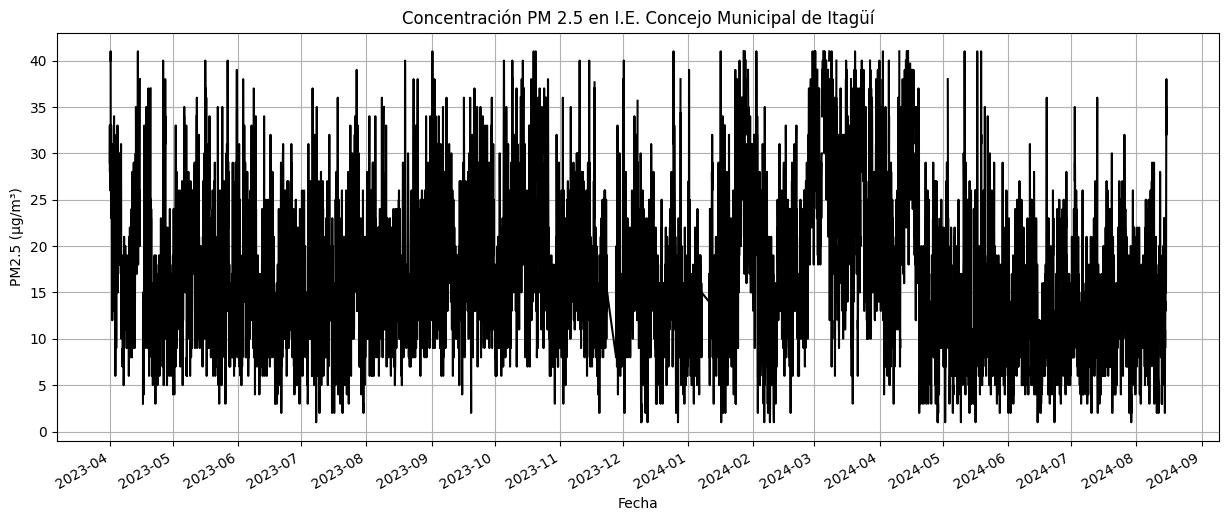

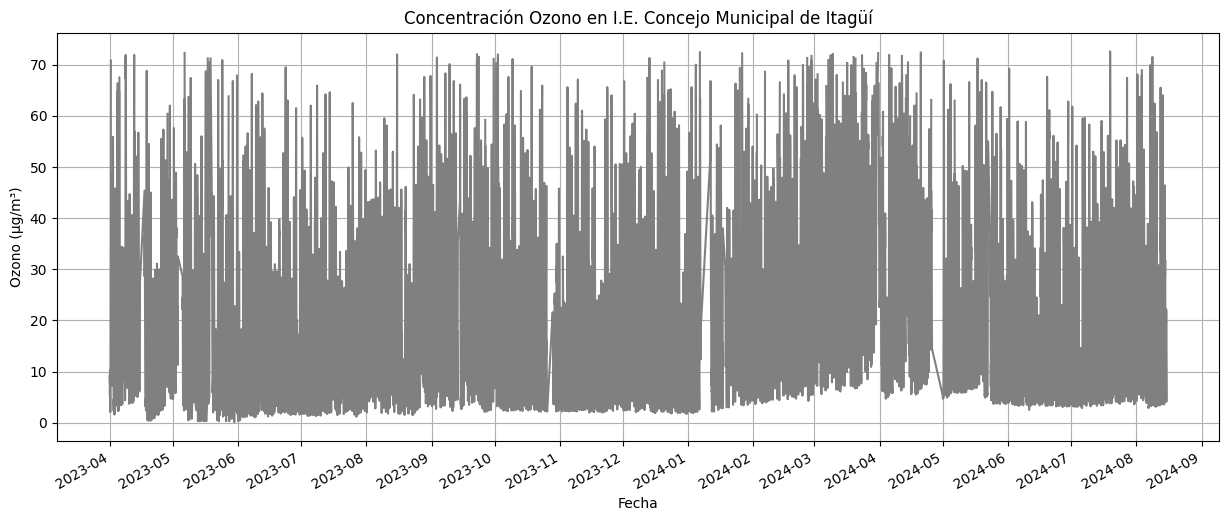

In [56]:
# Gráfica de PM25

plt.figure(figsize=(15, 6)) # Puedes ajustar el tamaño de la figura aquí
plt.plot(data_full.index, data_full['pm25'], color = "black")
plt.title('Concentración PM 2.5 en I.E. Concejo Municipal de Itagüí')
plt.xlabel('Fecha')
plt.ylabel('PM2.5 (µg/m³)')
plt.grid(True)

# Código para variar fechas
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate() # Formatea las fechas para que no se superpongan
plt.show()

# Gráfica de Ozono

plt.figure(figsize=(15, 6)) # Puedes ajustar el tamaño de la figura aquí
plt.plot(data_full.index, data_full['ozono'], color = "gray")
plt.title('Concentración Ozono en I.E. Concejo Municipal de Itagüí')
plt.xlabel('Fecha')
plt.ylabel('Ozono (µg/m³)')
plt.grid(True)

# Código para variar fechas
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate() # Formatea las fechas para que no se superpongan
plt.show()


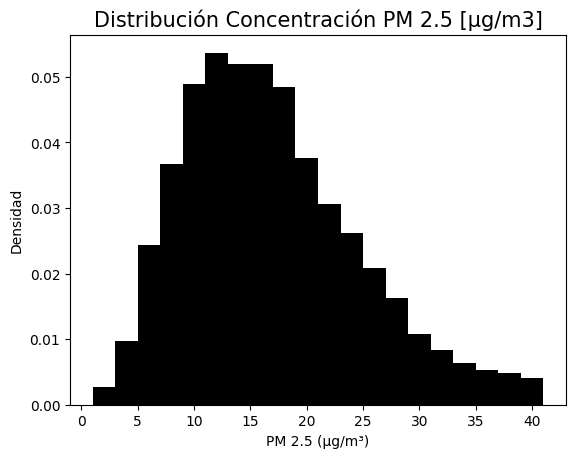

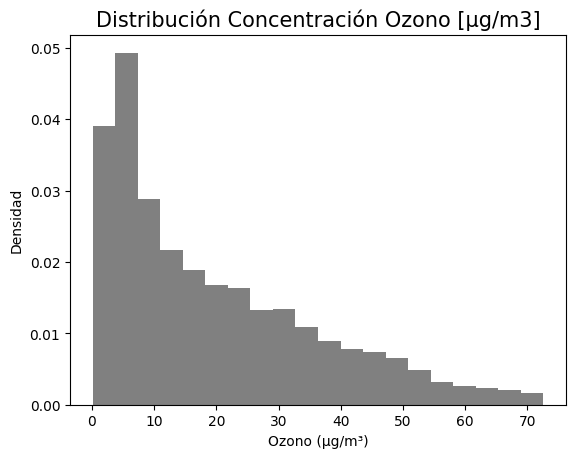

In [57]:
# Histograma de PM25

fig=plt.figure()
distribucion=plt.hist(pm25,bins=20,density=True,color="black")
plt.title('Distribución Concentración PM 2.5 [μg/m3]', fontsize=15)
plt.xlabel('PM 2.5 (µg/m³)')
plt.ylabel('Densidad')
plt.show()

fig=plt.figure()
distribucion=plt.hist(ozono,bins=20,density=True,color="gray")
plt.title('Distribución Concentración Ozono [μg/m3]', fontsize=15)
plt.xlabel('Ozono (µg/m³)')
plt.ylabel('Densidad')
plt.show()

/tmp/ipython-input-58-1177004741.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.boxplot( data = pm25, orient ="h",palette='viridis', showmeans=True)


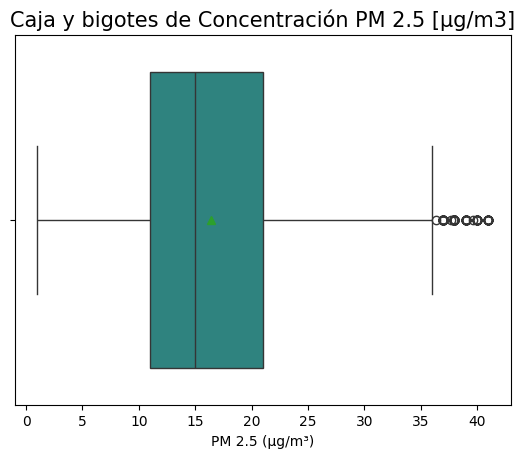

/tmp/ipython-input-58-1177004741.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.boxplot(data=ozono, orient="h", palette='viridis', showmeans=True)


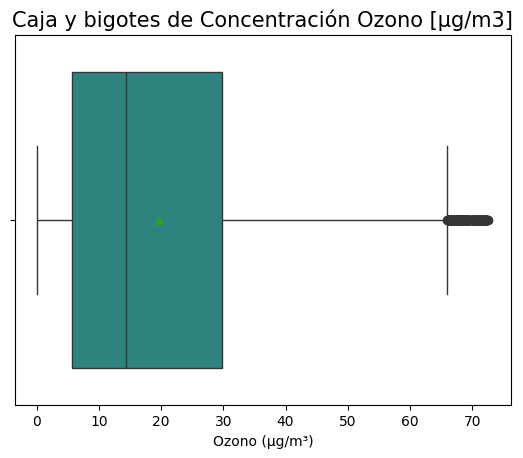

In [58]:
# Caja y bigotes PM25

fig = sns.boxplot( data = pm25, orient ="h",palette='viridis', showmeans=True)
plt.title('Caja y bigotes de Concentración PM 2.5 [μg/m3]', fontsize=15)
plt.xlabel('PM 2.5 (µg/m³)')
plt.show()

# Caja y bigotes Ozono

fig = sns.boxplot(data=ozono, orient="h", palette='viridis', showmeans=True)
plt.title('Caja y bigotes de Concentración Ozono [μg/m3]', fontsize=15)
plt.xlabel('Ozono (µg/m³)')
plt.show()


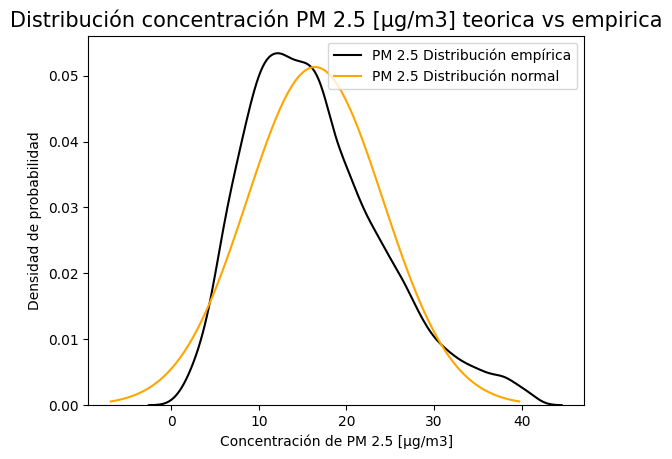

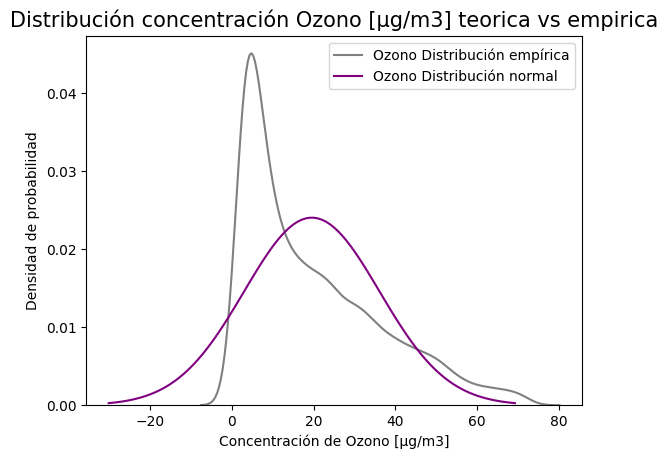

In [59]:
# Comparación distribución empirica con la normal PM 2.5

valormin = media_varf - desv_estandar*3
valormax = media_varf + desv_estandar*3
xplot = np.linspace(valormin, valormax,100)
yplot = ss.norm.pdf(xplot,media_varf,desv_estandar)
fig=plt.figure()
sns.kdeplot(pm25, color='black', label='PM 2.5 Distribución empírica')
plt.plot(xplot,yplot, color='orange', label="PM 2.5 Distribución normal" )
plt.title('Distribución concentración PM 2.5 [μg/m3] teorica vs empirica', fontsize=15)
plt.xlabel("Concentración de PM 2.5 [μg/m3]")
plt.ylabel("Densidad de probabilidad")
plt.legend(loc='upper right')
plt.show()


#Comparación distribución empirica con la normal Ozono

valormin_o3 = media_varo3 - desv_estandar_o3 * 3
valormax_o3 = media_varo3 + desv_estandar_o3 * 3
xplot_o3 = np.linspace(valormin_o3, valormax_o3, 100)
yplot_o3 = ss.norm.pdf(xplot_o3, media_varo3, desv_estandar_o3)
fig=plt.figure()
sns.kdeplot(ozono, color='gray', label='Ozono Distribución empírica')
plt.plot(xplot_o3, yplot_o3, color='purple', label="Ozono Distribución normal" )
plt.title('Distribución concentración Ozono [μg/m3] teorica vs empirica', fontsize=15)
plt.xlabel("Concentración de Ozono [μg/m3]")
plt.ylabel("Densidad de probabilidad")
plt.legend(loc='upper right')
plt.show()



In [60]:
# Pruebas estadisticas para los estadisticos de la gráfica empirica con los estadisticos de distribución normal PM 2.5
mediaNormal,desviacionNormal = ss.norm.fit(pm25)
varianzaNormal = desviacionNormal**2

print("\n--- Pruebas Estadísticas para PM 2.5 ---")

# Prueba Z
# Ho: μ = 16.407 ; H1: μ ≠ 16.407   α=2,5%
zstat, pvalue = ztest(pm25, value=mediaNormal, alternative="two-sided")
print("Prueba Z:")
print("El estadistico Z es:", zstat)
print("El valor P es:", pvalue)
if pvalue < 0.05:
  print("El valor P ({:.4f}) es menor que el nivel de significancia (0.05). Se rechaza la hipótesis nula.".format(pvalue))
else:
  print("El valor P ({:.4f}) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.".format(pvalue))


# Prueba F sobre la varianza para PM 2.5 Ho: σ²1 = σ²2 H1: σ²1 ≠ σ²2 α=2,5%; Por último, usé la prueba F =  σ²1 / σ²2 enseñada en clase. Hice una fución desde cero y la definí al principio

f_statisticnew, p_valuenew= pruebaf(varianzaNormal,variance_varf, len(xplot), len(pm25))

print("\nPrueba F sobre la varianza:")
print("El estadistico F es:", f_statisticnew)
print("El valor P es:", p_valuenew)
if p_valuenew < 0.05:
  print("El valor P ({:.4f}) es menor que el nivel de significancia (0.05). Se rechaza la hipótesis nula.".format(p_valuenew))
else:
  print("El valor P ({:.4f}) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.".format(p_valuenew))


# Pruebas estadisticas para los estadisticos de la gráfica empirica con los estadisticos de distribución normal Ozono
mediaNormal_o3, desviacionNormal_o3 = ss.norm.fit(ozono)
varianzaNormal_o3 = desviacionNormal_o3**2

# Prueba Z para Ozono
# Ho: μ = mediaNormal_o3 ; H1: μ ≠ mediaNormal_o3 α=2,5%
zstat_o3, pvalue_o3 = ztest(ozono, value=mediaNormal_o3, alternative="two-sided")
print("\n--- Pruebas Estadísticas para Ozono ---")
print("Prueba Z:")
print("El estadistico Z es:", zstat_o3)
print("El valor P es:", pvalue_o3)
if pvalue_o3 < 0.05:
  print("El valor P ({:.4f}) es menor que el nivel de significancia (0.05). Se rechaza la hipótesis nula.".format(pvalue_o3))
else:
  print("El valor P ({:.4f}) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.".format(pvalue_o3))


# Prueba F sobre la varianza para Ozono Ho: σ²1 = σ²2 H1: σ²1 ≠ σ²2 α=2,5%

f_statisticnew_o3, p_valuenew_o3 = pruebaf(varianzaNormal_o3, variance_varo3, len(xplot_o3), len(ozono))

print("\nPrueba F sobre la varianza:")
print("El estadistico F es:", f_statisticnew_o3)
print("El valor P es:", p_valuenew_o3)
if p_valuenew_o3 < 0.05:
  print("El valor P ({:.4f}) es menor que el nivel de significancia (0.05). Se rechaza la hipótesis nula.".format(p_valuenew_o3))
else:
  print("El valor P ({:.4f}) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.".format(p_valuenew_o3))



--- Pruebas Estadísticas para PM 2.5 ---
Prueba Z:
El estadistico Z es: 0.0
El valor P es: 1.0
El valor P (1.0000) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.

Prueba F sobre la varianza:
El estadistico F es: 1.0000853460783476
El valor P es: 0.9621935247151172
El valor P (0.9622) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.

--- Pruebas Estadísticas para Ozono ---
Prueba Z:
El estadistico Z es: 0.0
El valor P es: 1.0
El valor P (1.0000) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.

Prueba F sobre la varianza:
El estadistico F es: 1.0000854262771226
El valor P es: 0.9621935241616959
El valor P (0.9622) es mayor o igual que el nivel de significancia (0.05). No se puede rechazar la hipótesis nula.


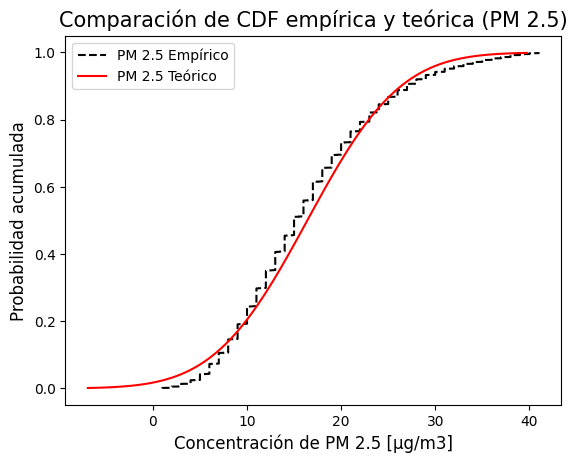


--- Prueba de Kolmogorov-Smirnov para PM 2.5 ---
El estadistico D es: 0.08441094434943996
El valor P es: 4.379177917153635e-73
El valor P (0.0000) es menor que el nivel de significancia (0.05).
Por lo cual, rechazamos la hipótesis nula y decimos que la función distributiva de los valores de PM 2.5 no se ajusta a una distribución normal.


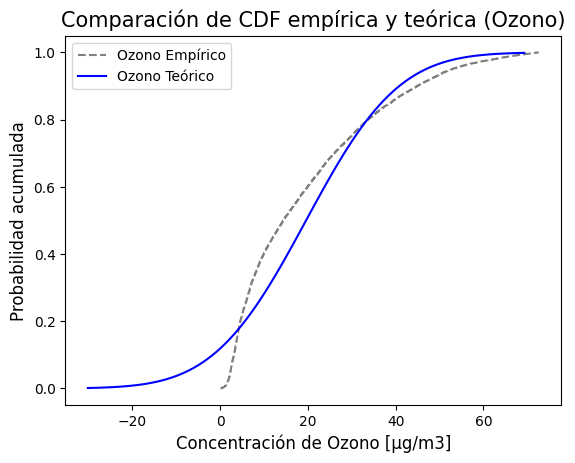


--- Prueba de Kolmogorov-Smirnov para Ozono ---
El estadistico D es: 0.12693887475015625
El valor P es: 6.673773402398168e-165
El valor P (0.0000) es menor que el nivel de significancia (0.05).
Por lo cual, rechazamos la hipótesis nula y decimos que la función distributiva de los valores de ozono no se ajusta a una distribución normal.


In [61]:
# Prueba para sabers si la función de distribución acumulada empírica es estadísticamente similar a la función de distribución acumulada de la distribución teórica.

x_emp = np.sort(pm25)
y_emp = np.arange(1, len(x_emp) + 1) / len(x_emp)
yplot_emp = ss.norm.cdf(xplot,media_varf,desv_estandar)

fig = plt.figure()
plt.plot(x_emp, y_emp, color='black', label='PM 2.5 Empírico', linestyle='--')
plt.plot(xplot,yplot_emp, color='red', label='PM 2.5 Teórico')
plt.xlabel('Concentración de PM 2.5 [μg/m3]', fontsize=12)
plt.ylabel('Probabilidad acumulada', fontsize=12)
plt.title('Comparación de CDF empírica y teórica (PM 2.5)', fontsize=15)
plt.legend()
plt.show()

# Prueba de Kolmogorov-Smirnov (KS)
# Ho : F(X) = Fo(X)   H1: F(X) ≠ Fo(X) α=2,5%

ks_statistic, p_valueks = ss.kstest(pm25, 'norm', args=(media_varf, desv_estandar), alternative='two-sided')

print("\n--- Prueba de Kolmogorov-Smirnov para PM 2.5 ---")
print("El estadistico D es:", ks_statistic)
print("El valor P es:", p_valueks)

if p_valueks < 0.05:
  print(f"El valor P ({p_valueks:.4f}) es menor que el nivel de significancia (0.05).")
  print("Por lo cual, rechazamos la hipótesis nula y decimos que la función distributiva de los valores de PM 2.5 no se ajusta a una distribución normal.")
else:
  print(f"El valor P ({p_valueks:.4f}) es mayor o igual que el nivel de significancia (0.05).")
  print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para decir que la distribución de PM 2.5 difiere de la normal.")

# Prueba para saber si la función de distribución acumulada empírica es estadísticamente similar a la función de distribución acumulada de la distribución teórica para Ozono.

x_emp_o3 = np.sort(ozono)
y_emp_o3 = np.arange(1, len(x_emp_o3) + 1) / len(x_emp_o3)
yplot_emp_o3 = ss.norm.cdf(xplot_o3, media_varo3, desv_estandar_o3)

fig = plt.figure()
plt.plot(x_emp_o3, y_emp_o3, color='gray', label='Ozono Empírico', linestyle='--')
plt.plot(xplot_o3, yplot_emp_o3, color='blue', label='Ozono Teórico')
plt.xlabel('Concentración de Ozono [μg/m3]', fontsize=12)
plt.ylabel('Probabilidad acumulada', fontsize=12)
plt.title('Comparación de CDF empírica y teórica (Ozono)', fontsize=15)
plt.legend()
plt.show()

# Prueba de Kolmogorov-Smirnov (KS) para Ozono
# Ho : F(X) = Fo(X)   H1: F(X) ≠ Fo(X) α=2,5%

ks_statistic_o3, p_valueks_o3 = ss.kstest(ozono, 'norm', args=(media_varo3, desv_estandar_o3), alternative='two-sided')

print("\n--- Prueba de Kolmogorov-Smirnov para Ozono ---")
print("El estadistico D es:", ks_statistic_o3)
print("El valor P es:", p_valueks_o3)

if p_valueks_o3 < 0.05:
  print(f"El valor P ({p_valueks_o3:.4f}) es menor que el nivel de significancia (0.05).")
  print("Por lo cual, rechazamos la hipótesis nula y decimos que la función distributiva de los valores de ozono no se ajusta a una distribución normal.")
else:
  print(f"El valor P ({p_valueks_o3:.4f}) es mayor o igual que el nivel de significancia (0.05).")
  print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para decir que la distribución de ozono difiere de la normal.")


In [62]:
# Prueba para analizar el cambio en la varianza de la variable partiendo la serie de tiempo PM 2.5

# Ho: σ²1 = σ²2 H1: σ²1 ≠ σ²2 α=2,5%

n = len(pm25)
nmeddos = int(n/2)
tads1 = pm25[0:nmeddos]
tads2 = pm25[nmeddos:n]

dates1 = dates_f[0:nmeddos]
dates2 = dates_f[nmeddos:n]

#Prueba sobre la varianza el el primer y segundo periodo

# Ho: σ²1 = σ²2 H1: σ²1 ≠ σ²2
Fnew_statistic, Fnew_valuef = ss.levene(tads1, tads2)
print("\n--- Prueba de Levene para PM 2.5 (cambio en la varianza) ---")
print( "El estadistico de Levene es:", Fnew_statistic)
print( "El valor P es:", Fnew_valuef)

if Fnew_valuef < 0.05:
  print(f"El valor P ({Fnew_valuef:.4f}) es menor que el nivel de significancia (0.05).")
  print("Por lo cual, rechazamos la hipótesis nula y decimos que la varianza de los dos periodos para PM 2.5 es estadísticamente diferente.")
else:
  print(f"El valor P ({Fnew_valuef:.4f}) es mayor o igual que el nivel de significancia (0.05).")
  print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para decir que la varianza de los dos periodos para PM 2.5 difiere.")

# Prueba para analizar el cambio en la varianza de la variable partiendo la serie de tiempo Ozono

# Ho: σ²1 = σ²2 H1: σ²1 ≠ σ²2 α=2,5%

n_o3 = len(ozono)
nmeddos_o3 = int(n_o3/2)
tads1_o3 = ozono[0:nmeddos_o3]
tads2_o3 = ozono[nmeddos_o3:n_o3]

dates1_o3 = dates_fo3[0:nmeddos_o3]
dates2_o3 = dates_fo3[nmeddos_o3:n_o3]

#Prueba sobre la varianza en el primer y segundo periodo
# Ho: σ²1 = σ²2 H1: σ²1 ≠ σ²2
Fnew_statistic_o3, Fnew_valuef_o3 = ss.levene(tads1_o3, tads2_o3)
print("\n--- Prueba de Levene para Ozono (cambio en la varianza) ---")
print( "El estadistico de Levene es:", Fnew_statistic_o3)
print( "El valor P es:", Fnew_valuef_o3)

if Fnew_valuef_o3 < 0.05:
  print(f"El valor P ({Fnew_valuef_o3:.4f}) es menor que el nivel de significancia (0.05).")
  print("Por lo cual, rechazamos la hipótesis nula y decimos que la varianza de los dos periodos para Ozono es estadísticamente diferente.")
else:
  print(f"El valor P ({Fnew_valuef_o3:.4f}) es mayor o igual que el nivel de significancia (0.05).")
  print("No se puede rechazar la hipótesis nula. No hay suficiente evidencia para decir que la varianza de los dos periodos para Ozono difiere.")


--- Prueba de Levene para PM 2.5 (cambio en la varianza) ---
El estadistico de Levene es: 251.80142762593167
El valor P es: 4.0328607347578034e-56
El valor P (0.0000) es menor que el nivel de significancia (0.05).
Por lo cual, rechazamos la hipótesis nula y decimos que la varianza de los dos periodos para PM 2.5 es estadísticamente diferente.

--- Prueba de Levene para Ozono (cambio en la varianza) ---
El estadistico de Levene es: 21.908116011944642
El valor P es: 2.8923097500853282e-06
El valor P (0.0000) es menor que el nivel de significancia (0.05).
Por lo cual, rechazamos la hipótesis nula y decimos que la varianza de los dos periodos para Ozono es estadísticamente diferente.


In [63]:
# Preparando datos de Ozono y PM 2.5 para los siguientes procesos

# Drop missing values
data_full_cleaned = data_full.dropna()

# Actualización de valores
pm25 = data_full_cleaned['pm25'].values
ozono = data_full_cleaned['ozono'].values

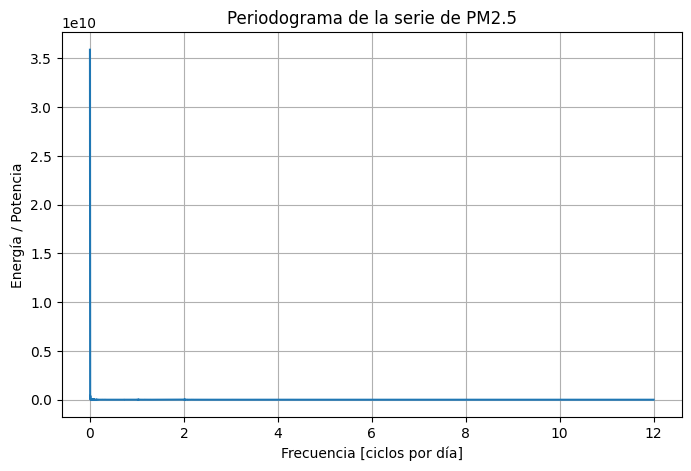

Frecuencia(s) dominante(s) en PM2.5: [6.20475698e-03 1.44777663e-02 2.06825233e-02 ... 1.19875905e+01
 1.19917270e+01 1.19958635e+01] ciclos por día


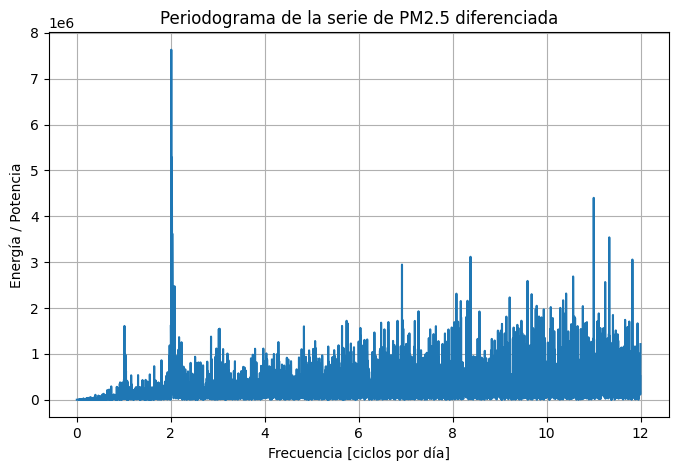

Frecuencia(s) dominante(s) en PM2.5 diferenciada: [6.20529173e-03 1.24105835e-02 2.48211669e-02 ... 1.19741446e+01
 1.19803499e+01 1.19886236e+01] ciclos por día


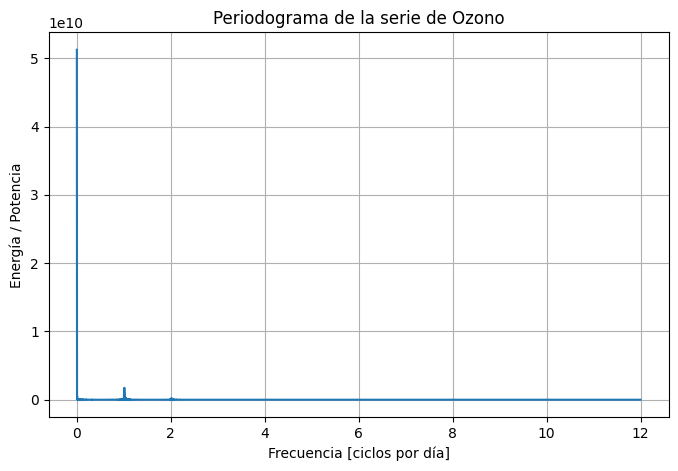

Frecuencia(s) dominante(s) en Ozono: [6.20475698e-03 1.03412616e-02 1.65460186e-02 ... 1.19813857e+01
 1.19855222e+01 1.19958635e+01] ciclos por día


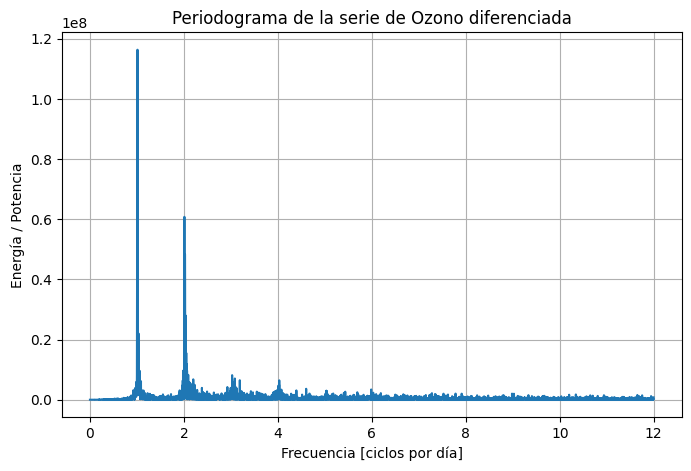

Frecuencia(s) dominante(s) en Ozono diferenciada: [6.20529173e-03 1.24105835e-02 2.06843058e-02 ... 1.19824183e+01
 1.19865552e+01 1.19906921e+01] ciclos por día


In [64]:
# Periodograma para PM 2.5

#aplicamos tranformada rápida de Fourier

y_ft_pm25 = scp.fft.fft(pm25)
# Corregir el cálculo de frecuencias a ciclos por día
freqs_pm25 = scp.fft.fftfreq(len(pm25)) * 24


#graficamos periodograma
plt.subplots(figsize=(8, 5)) # Ajustar tamaño para mejor visualización
# Usar la magnitud al cuadrado para el periodograma (potencia)
plt.plot(freqs_pm25[:len(freqs_pm25)//2], np.abs(y_ft_pm25)[:len(y_ft_pm25)//2]**2) # Graficar solo la mitad positiva de las frecuencias
plt.ylabel('Energía / Potencia')
plt.xlabel('Frecuencia [ciclos por día]') # Corregir la etiqueta del eje X
plt.title('Periodograma de la serie de PM2.5') # Añadir título explícito
plt.grid(True)
plt.show()

# Encontrar picos en la mitad positiva del espectro
peaks_pm25 = scp.signal.find_peaks(np.abs(y_ft_pm25)[:len(y_ft_pm25)//2]**2)
peak_indices_pm25 = peaks_pm25[0]
# Convertir índices de picos a frecuencias
peak_freqs_pm25 = freqs_pm25[peak_indices_pm25]

print('Frecuencia(s) dominante(s) en PM2.5:', peak_freqs_pm25, 'ciclos por día')

# Análisis de la serie diferenciada de PM2.5
pm25_diff = np.diff(pm25)

y_ft_pm25_diff = scp.fft.fft(pm25_diff)
# Corregir el cálculo de frecuencias a ciclos por día
freqs_pm25_diff = scp.fft.fftfreq(len(pm25_diff)) * 24

plt.figure(figsize=(8, 5)) # Ajustar tamaño
# Usar la magnitud al cuadrado para el periodograma (potencia)
plt.plot(freqs_pm25_diff[:len(freqs_pm25_diff)//2], np.abs(y_ft_pm25_diff)[:len(y_ft_pm25_diff)//2]**2) # Graficar solo la mitad positiva
plt.title('Periodograma de la serie de PM2.5 diferenciada')
plt.ylabel('Energía / Potencia')
plt.xlabel('Frecuencia [ciclos por día]') # Corregir la etiqueta
plt.grid(True)
plt.show()

# Encontrar picos en la mitad positiva del espectro diferenciado
peaks_pm25_diff = scp.signal.find_peaks(np.abs(y_ft_pm25_diff)[:len(y_ft_pm25_diff)//2]**2)
peak_indices_diff = peaks_pm25_diff[0]
# Convertir índices de picos a frecuencias
peak_freqs_diff = freqs_pm25_diff[peak_indices_diff]


print('Frecuencia(s) dominante(s) en PM2.5 diferenciada:', peak_freqs_diff, 'ciclos por día')

# Periodograma para Ozono

# aplicamos tranformada rápida de Fourier
y_ft_ozono = scp.fft.fft(ozono)
# Calcular frecuencias en ciclos por día
freqs_ozono = scp.fft.fftfreq(len(ozono)) * 24

# graficamos periodograma para Ozono original
plt.figure(figsize=(8, 5)) # Ajustar tamaño para mejor visualización
# Usar la magnitud al cuadrado para el periodograma (potencia)
plt.plot(freqs_ozono[:len(freqs_ozono)//2], np.abs(y_ft_ozono)[:len(y_ft_ozono)//2]**2) # Graficar solo la mitad positiva
plt.ylabel('Energía / Potencia')
plt.xlabel('Frecuencia [ciclos por día]')
plt.title('Periodograma de la serie de Ozono')
plt.grid(True)
plt.show()

# Encontrar picos en la mitad positiva del espectro de Ozono
peaks_ozono = scp.signal.find_peaks(np.abs(y_ft_ozono)[:len(y_ft_ozono)//2]**2)
peak_indices_ozono = peaks_ozono[0]
# Convertir índices de picos a frecuencias
peak_freqs_ozono = freqs_ozono[peak_indices_ozono]

print('Frecuencia(s) dominante(s) en Ozono:', peak_freqs_ozono, 'ciclos por día')

# Análisis de la serie diferenciada de Ozono
ozono_diff = np.diff(ozono)

y_ft_ozono_diff = scp.fft.fft(ozono_diff)
# Calcular frecuencias en ciclos por día
freqs_ozono_diff = scp.fft.fftfreq(len(ozono_diff)) * 24

plt.figure(figsize=(8, 5)) # Ajustar tamaño
# Usar la magnitud al cuadrado para el periodograma (potencia)
plt.plot(freqs_ozono_diff[:len(freqs_ozono_diff)//2], np.abs(y_ft_ozono_diff)[:len(y_ft_ozono_diff)//2]**2) # Graficar solo la mitad positiva
plt.title('Periodograma de la serie de Ozono diferenciada')
plt.ylabel('Energía / Potencia')
plt.xlabel('Frecuencia [ciclos por día]')
plt.grid(True)
plt.show()

# Encontrar picos en la mitad positiva del espectro diferenciado de Ozono
peaks_ozono_diff = scp.signal.find_peaks(np.abs(y_ft_ozono_diff)[:len(y_ft_ozono_diff)//2]**2)
peak_indices_ozono_diff = peaks_ozono_diff[0]
# Convertir índices de picos a frecuencias
peak_freqs_ozono_diff = freqs_ozono_diff[peak_indices_ozono_diff]

print('Frecuencia(s) dominante(s) en Ozono diferenciada:', peak_freqs_ozono_diff, 'ciclos por día')

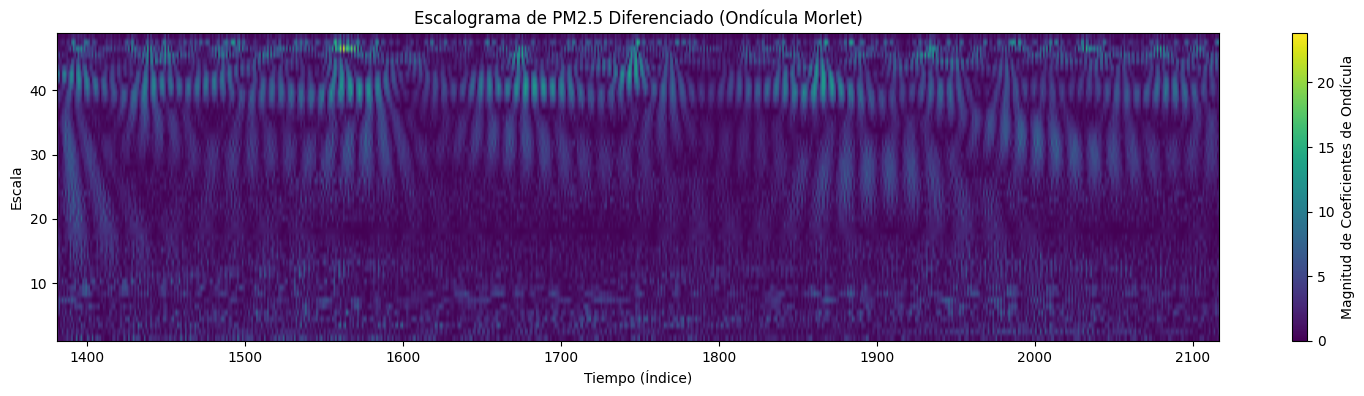

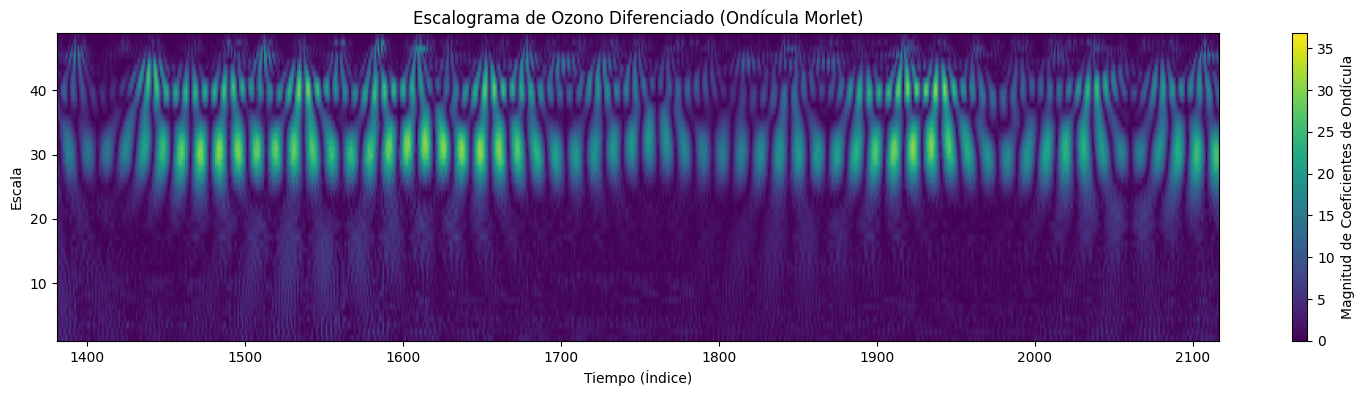

In [65]:
# Onditas

# Usar la ondícula Morlet ('morl') en PM2.5

# El mapeo exacto de escala a período depende de la wavelet, un rango mayor explora períodos más largos
scales = range(1, 50) # Rango de escalas más amplio

coeffs_pm25, freqs_pm25 = pywt.cwt(pm25_diff, scales, wavelet='morl')
plt.subplots(figsize=(18.75, 4)) # Ajustar tamaño de figura para mejor visualización vertical de escalas
# Limitar el eje X a un rango de fechas de 1 mes para ver detalles temporales
start_date_wavelet = '2023-06-01'
end_date_wavelet = '2023-07-01'
time_index = data_full_cleaned.index
# Encontrar la posición numérica de las fechas de inicio y fin en el índice
# Usar get_loc sin 'method' y convertir a lista para manejar posibles índices no únicos, luego tomar el primero
start_idx = time_index.get_loc(start_date_wavelet)
if isinstance(start_idx, slice):
    start_idx = start_idx.start
end_idx = time_index.get_loc(end_date_wavelet)
if isinstance(end_idx, slice):
    end_idx = end_idx.stop -1

# Asegurarse de que los índices estén dentro del rango de los coeficientes (N-1)
start_idx = max(0, start_idx)
end_idx = min(end_idx, coeffs_pm25.shape[1] -1)

plt.imshow(np.abs(coeffs_pm25), aspect='auto', extent=[0, coeffs_pm25.shape[1], scales[0], scales[-1]], cmap='viridis') # Graficar la magnitud de los coeficientes complejos
plt.xlim(start_idx, end_idx) # Limitar el eje X al rango de 1 mes en índices
plt.ylabel('Escala')
plt.xlabel('Tiempo (Índice)')
plt.title('Escalograma de PM2.5 Diferenciado (Ondícula Morlet)')
plt.colorbar(label='Magnitud de Coeficientes de Ondícula')


# Usar la ondícula Morlet ('morl') en ozono
coeffs_ozono, freqs_ozono = pywt.cwt(ozono_diff, scales, wavelet='morl')
plt.subplots(figsize=(18.75, 4))
start_idx_ozono = time_index.get_loc(start_date_wavelet)
if isinstance(start_idx_ozono, slice):
    start_idx_ozono = start_idx_ozono.start
end_idx_ozono = time_index.get_loc(end_date_wavelet)
if isinstance(end_idx_ozono, slice):
    end_idx_ozono = end_idx_ozono.stop -1

start_idx_ozono = max(0, start_idx_ozono)
end_idx_ozono = min(end_idx_ozono, coeffs_ozono.shape[1] - 1)

plt.imshow(np.abs(coeffs_ozono), aspect='auto', extent=[0, coeffs_ozono.shape[1], scales[0], scales[-1]], cmap='viridis')
plt.xlim(start_idx_ozono, end_idx_ozono)
plt.ylabel('Escala')
plt.xlabel('Tiempo (Índice)')
plt.title('Escalograma de Ozono Diferenciado (Ondícula Morlet)')
plt.colorbar(label='Magnitud de Coeficientes de Ondícula')


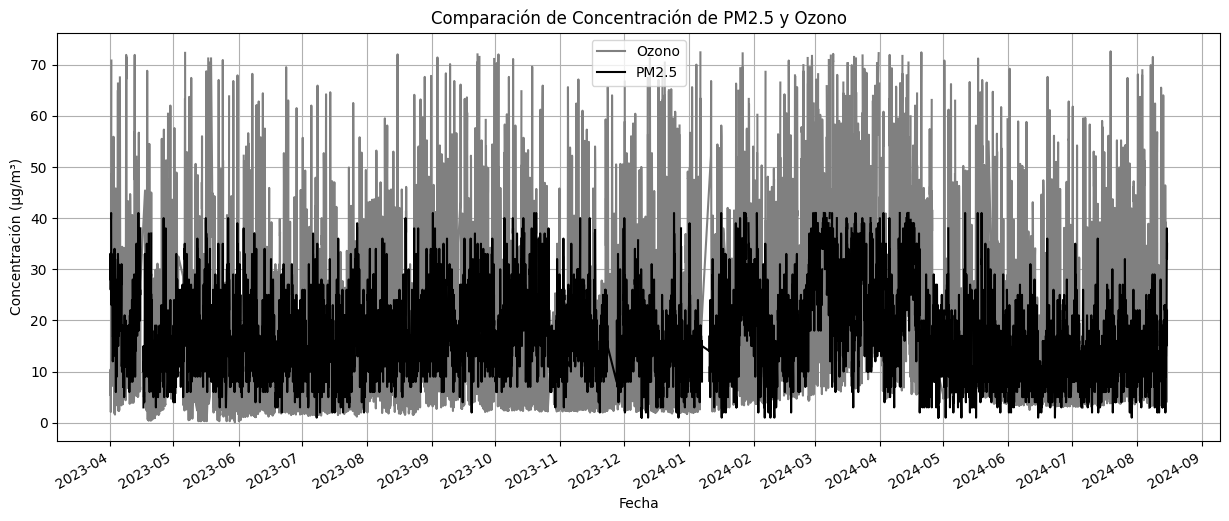

In [66]:
# Gráfica para comparar PM2.5 y Ozono
plt.figure(figsize=(15, 6))
plt.plot(data_full.index, data_full['ozono'], label='Ozono', color='grey')
plt.plot(data_full.index, data_full['pm25'], label='PM2.5', color='black')

plt.title('Comparación de Concentración de PM2.5 y Ozono')
plt.xlabel('Fecha')
plt.ylabel('Concentración (µg/m³)')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.show()


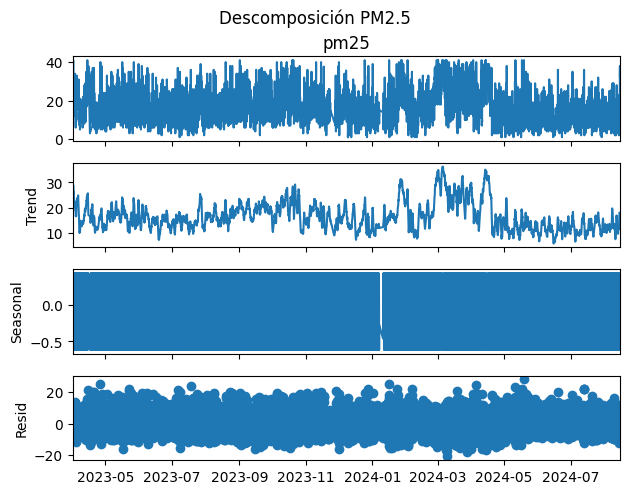

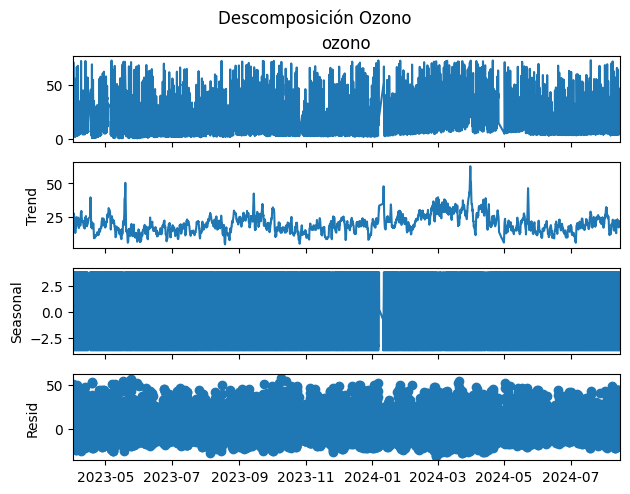

In [67]:
# Descomposición de las series de tiempo en sus componentes. Me interesa el componente diario entonces voy a hacer un periodo de 24

decomp_pm25 = seasonal_decompose(data_full_cleaned["pm25"], model="additive", period=24)

fig2 = decomp_pm25.plot()
fig2.suptitle("Descomposición PM2.5", y=1.02)
plt.show()

decomp_ozono = seasonal_decompose(data_full_cleaned["ozono"], model="additive", period=24)

fig3 = decomp_ozono.plot()
fig3.suptitle("Descomposición Ozono", y=1.02)
plt.show()

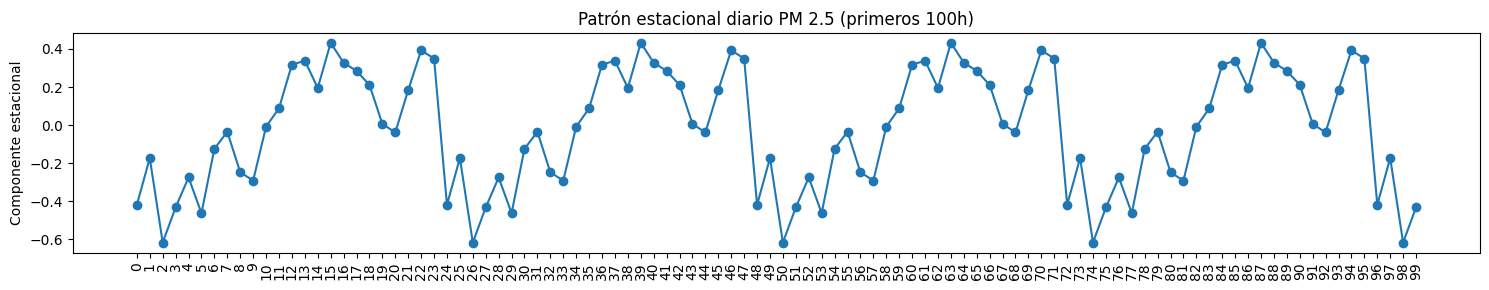

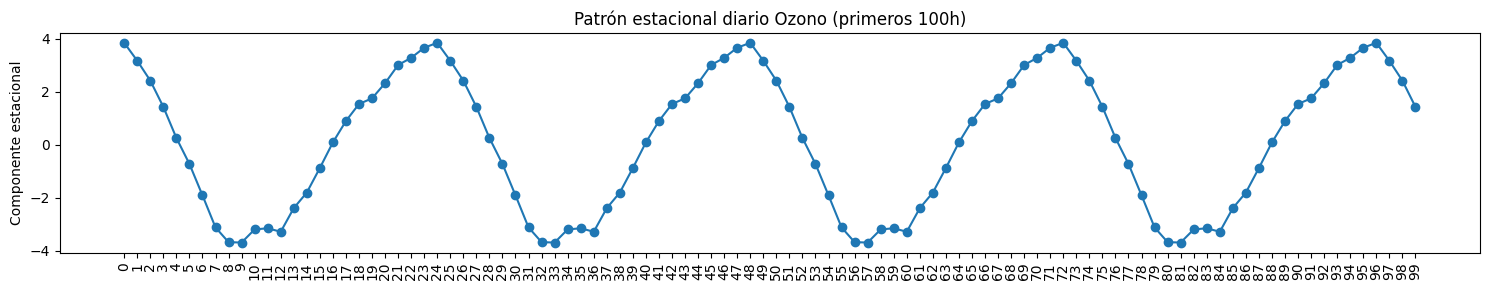

In [68]:
# Componente estacional pm25 y ozono

periodo = 100
s = decomp_pm25.seasonal   # es un numpy.ndarray de longitud N

plt.figure(figsize=(15, 3))
plt.plot(range(periodo), s[:periodo], marker='o')
plt.xticks(range(periodo), range(periodo), rotation=90)
plt.title("Patrón estacional diario PM 2.5 (primeros 100h)")
plt.xlabel("")
plt.ylabel("Componente estacional")
plt.tight_layout()
plt.show()

s_ozono = decomp_ozono.seasonal   # es un numpy.ndarray de longitud N

plt.figure(figsize=(15, 3))
plt.plot(range(periodo), s_ozono[:periodo], marker='o')
plt.xticks(range(periodo), range(periodo), rotation=90)
plt.title("Patrón estacional diario Ozono (primeros 100h)")
plt.xlabel("")
plt.ylabel("Componente estacional")
plt.tight_layout()
plt.show()
plt.show()

In [69]:
# Calcular el ciclo diario promedio
# Agrupar los datos por la hora del día y calcular la media
pm25_daily_cycle = data_full['pm25'].groupby(data_full.index.hour).mean()
ozono_daily_cycle = data_full['ozono'].groupby(data_full.index.hour).mean()

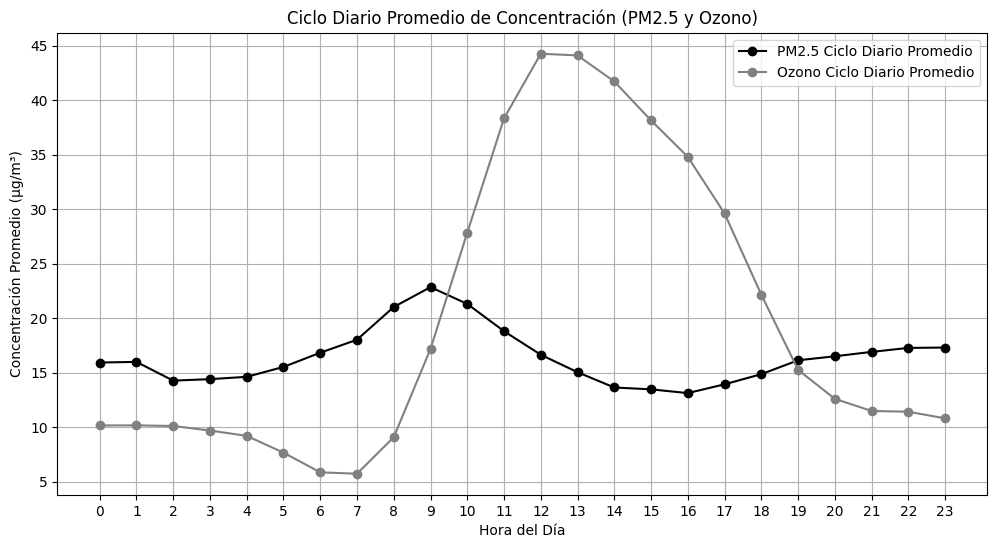

In [70]:
# Graficar el ciclo diario promedio
plt.figure(figsize=(12, 6))

# Gráfica para PM2.5
plt.plot(pm25_daily_cycle.index, pm25_daily_cycle.values, marker='o', color='black', label='PM2.5 Ciclo Diario Promedio')

# Gráfica para Ozono
plt.plot(ozono_daily_cycle.index, ozono_daily_cycle.values, marker='o', color='grey', label='Ozono Ciclo Diario Promedio')

plt.title('Ciclo Diario Promedio de Concentración (PM2.5 y Ozono)')
plt.xlabel('Hora del Día')
plt.ylabel('Concentración Promedio (μg/m³)')
plt.xticks(range(0, 24)) # Asegura que se muestren todas las horas de 0 a 23
plt.grid(True)
plt.legend()
plt.show()

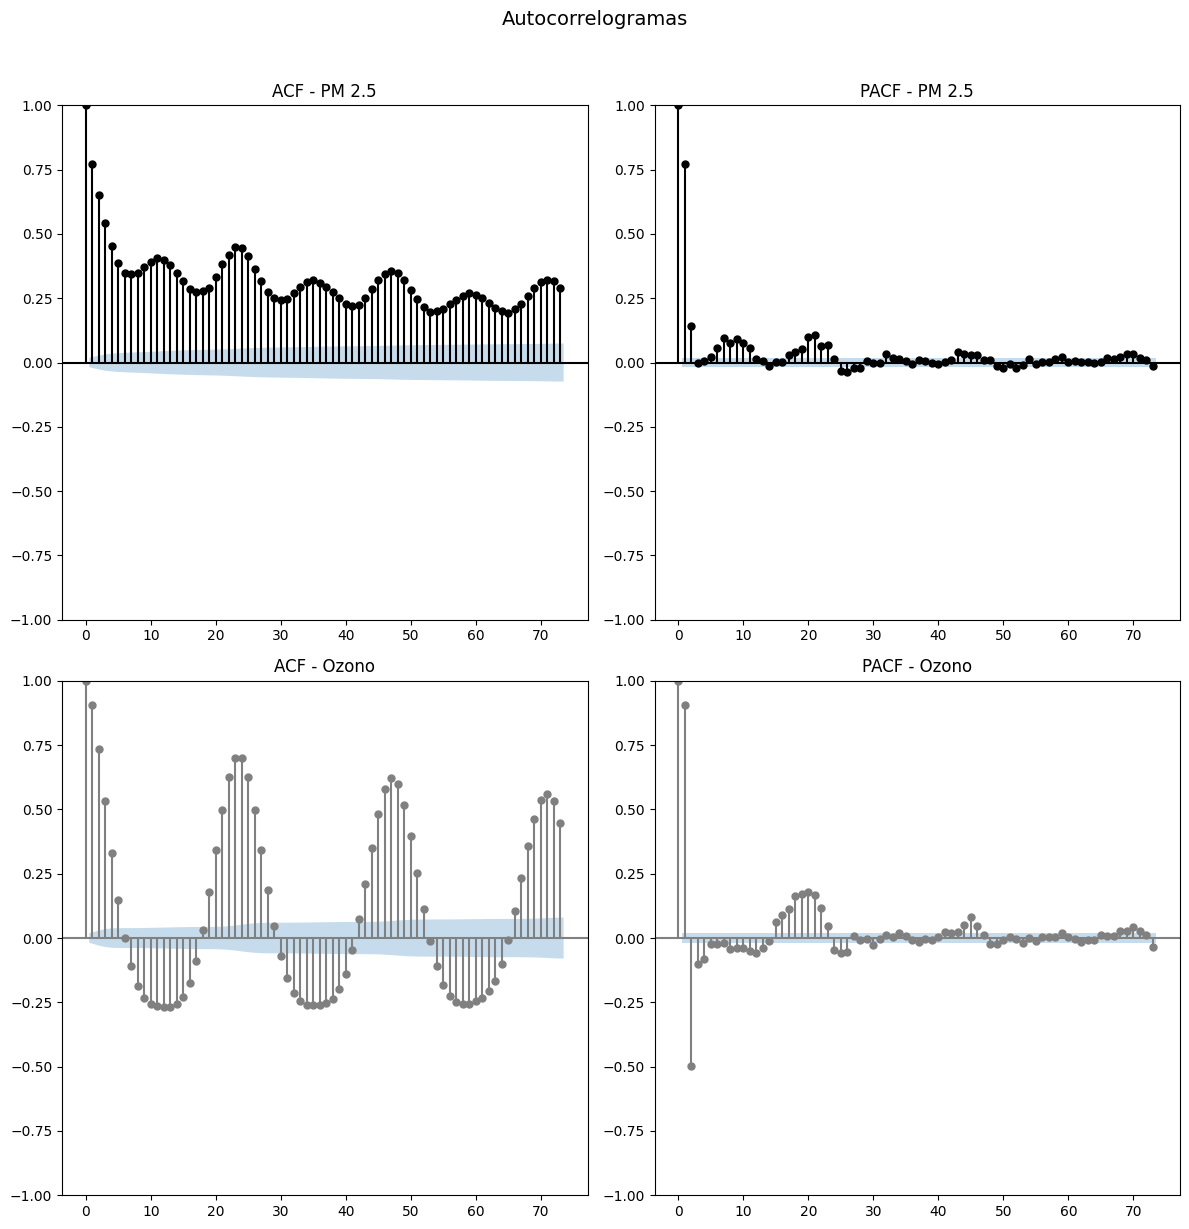

In [71]:

# Autocorrelogramas para PM 2.5 y Ozono
data_full_2 = data_full.dropna()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
fig.suptitle('Autocorrelogramas', y=1.02, fontsize=14)

# Primer conjunto de datos
plot_acf(data_full_2["pm25"], lags=73, ax=axes[0, 0], title='ACF - PM 2.5', color='black', vlines_kwargs={'colors': 'black'})
plot_pacf(data_full_2["pm25"], lags=73, ax=axes[0, 1], title='PACF - PM 2.5',color='black', vlines_kwargs={'colors': 'black'})

# Tercer conjunto de datos
plot_acf(data_full_2["ozono"], lags=73, ax=axes[1, 0], title='ACF - Ozono', color='gray', vlines_kwargs={'colors': 'gray'})
plot_pacf(data_full_2["ozono"], lags=73, ax=axes[1, 1], title='PACF - Ozono', color='gray', vlines_kwargs={'colors': 'gray'})


plt.tight_layout()
plt.show()

In [72]:
# Prueba de Mann-Kendall para las series de tiempo

# Aplicar prueba de Mann-Kendall a la serie de tiempo de PM2.5
mk_pm25 = mk.original_test(data_full_cleaned['pm25'])

print("\nResultados de la prueba de Mann-Kendall para PM2.5:")
print(f"Tendencia: {mk_pm25.trend}")
print(f"Valor h (Indica la presencia de tendencia): {mk_pm25.h}") # h=True significa tendencia significativa
print(f"Valor p: {mk_pm25.p}")
print(f"Estadístico Z: {mk_pm25.z}")
print(f"Estadístico S: {mk_pm25.s}")
print(f"Variancia de S: {mk_pm25.var_s}")
print(f"Pendiente de Sen: {mk_pm25.slope}")
print(f"Intercepción de Sen: {mk_pm25.intercept}")

# Aplicar prueba de Mann-Kendall a la serie de tiempo de Ozono
mk_ozono = mk.original_test(data_full_cleaned['ozono'])

print("\nResultados de la prueba de Mann-Kendall para Ozono:")
print(f"Tendencia: {mk_ozono.trend}")
print(f"Valor h (Indica la presencia de tendencia): {mk_ozono.h}") # h=True significa tendencia significativa
print(f"Valor p: {mk_ozono.p}")
print(f"Estadístico Z: {mk_ozono.z}")
print(f"Estadístico S: {mk_ozono.s}")
print(f"Variancia de S: {mk_ozono.var_s}")
print(f"Pendiente de Sen: {mk_ozono.slope}")
print(f"Intercepción de Sen: {mk_ozono.intercept}")



Resultados de la prueba de Mann-Kendall para PM2.5:
Tendencia: decreasing
Valor h (Indica la presencia de tendencia): True
Valor p: 0.0
Estadístico Z: -12.50241991384633
Estadístico S: -5205476.0
Variancia de S: 173353481268.66666
Pendiente de Sen: -0.00023730422401518748
Intercepción de Sen: 16.37672045562411

Resultados de la prueba de Mann-Kendall para Ozono:
Tendencia: increasing
Valor h (Indica la presencia de tendencia): True
Valor p: 0.0
Estadístico Z: 10.864086417387712
Estadístico S: 4526987.0
Variancia de S: 173632844412.33334
Pendiente de Sen: 0.0002945841830954
Intercepción de Sen: 12.590969861772038


In [73]:
# Aplicar prueba de Mann-Kendall con pre-whitening a la serie de tiempo de PM2.5
mk_pm25_pw = mk.pre_whitening_modification_test(data_full_cleaned['pm25'])

print("\nResultados de la prueba de Mann-Kendall con Pre-whitening para PM2.5:")
print(f"Tendencia: {mk_pm25_pw.trend}")
print(f"Valor h (Indica la presencia de tendencia): {mk_pm25_pw.h}")
print(f"Valor p: {mk_pm25_pw.p}")
print(f"Estadístico Z: {mk_pm25_pw.z}")
print(f"Estadístico S: {mk_pm25_pw.s}")
print(f"Variancia de S: {mk_pm25_pw.var_s}")
print(f"Pendiente de Sen: {mk_pm25_pw.slope}")
print(f"Intercepción de Sen: {mk_pm25_pw.intercept}")


# Aplicar prueba de Mann-Kendall con pre-whitening a la serie de tiempo de Ozono
mk_ozono_pw = mk.pre_whitening_modification_test(data_full_cleaned['ozono'])

print("\nResultados de la prueba de Mann-Kendall con Pre-whitening para Ozono:")
print(f"Tendencia: {mk_ozono_pw.trend}")
print(f"Valor h (Indica la presencia de tendencia): {mk_ozono_pw.h}")
print(f"Valor p: {mk_ozono_pw.p}")
print(f"Estadístico Z: {mk_ozono_pw.z}")
print(f"Estadístico S: {mk_ozono_pw.s}")
print(f"Variancia de S: {mk_ozono_pw.var_s}")
print(f"Pendiente de Sen: {mk_ozono_pw.slope}")
print(f"Intercepción de Sen: {mk_ozono_pw.intercept}")



Resultados de la prueba de Mann-Kendall con Pre-whitening para PM2.5:
Tendencia: decreasing
Valor h (Indica la presencia de tendencia): True
Valor p: 6.97507196489866e-06
Estadístico Z: -4.4944477717903615
Estadístico S: -1872565.0
Variancia de S: 173588385373.66666
Pendiente de Sen: -0.00023730422401518748
Intercepción de Sen: 16.37672045562411

Resultados de la prueba de Mann-Kendall con Pre-whitening para Ozono:
Tendencia: no trend
Valor h (Indica la presencia de tendencia): False
Valor p: 0.13515993463718723
Estadístico Z: 1.4940600114894904
Estadístico S: 622488.0
Variancia de S: 173589914044.66666
Pendiente de Sen: 0.0002945841830954
Intercepción de Sen: 12.590969861772038


In [74]:
#Prueba de estacionariedad para PM25 y Ozono
result = adfuller(pm25)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
print("-----------------------------------------")
result = adfuller(ozono)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])
print("-----------------------------------------")


ADF Statistic: -8.668929469179668
p-value: 4.60261500965622e-14
Critical Values: {'1%': np.float64(-3.43091531991482), '5%': np.float64(-2.861789841507824), '10%': np.float64(-2.566902985547369)}
-----------------------------------------
ADF Statistic: -10.837984113682031
p-value: 1.643339449397718e-19
Critical Values: {'1%': np.float64(-3.43091512449565), '5%': np.float64(-2.861789755151101), '10%': np.float64(-2.5669029395800202)}
-----------------------------------------


Primeras 10 anomalías de PM2.5 sin tendencia:
[ 0.51764847 -0.64706058  0.12941212  0.38823635 -0.7764727   0.51764847
  0.38823635  0.90588482  0.12941212 -1.03529693]

Primeras 10 anomalías de Ozono sin tendencia:
[ 0.22957266 -0.09062079  0.15707603 -0.2537382  -0.0845794  -0.16311741
  0.01208277  1.2264013   0.47726947  0.79746292]


<Figure size 1200x600 with 0 Axes>

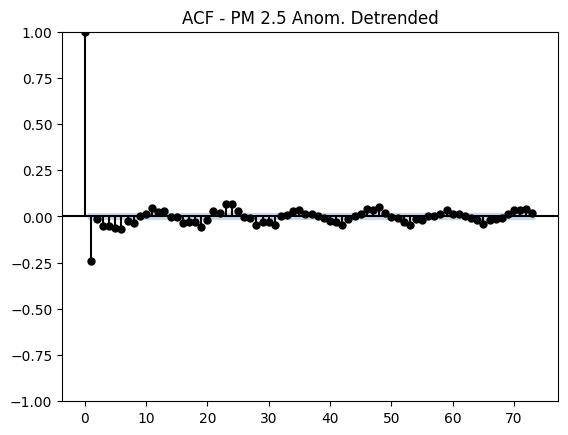

<Figure size 1200x600 with 0 Axes>

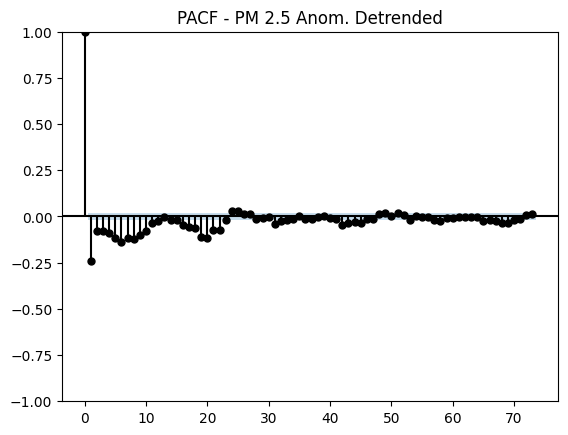

<Figure size 1200x600 with 0 Axes>

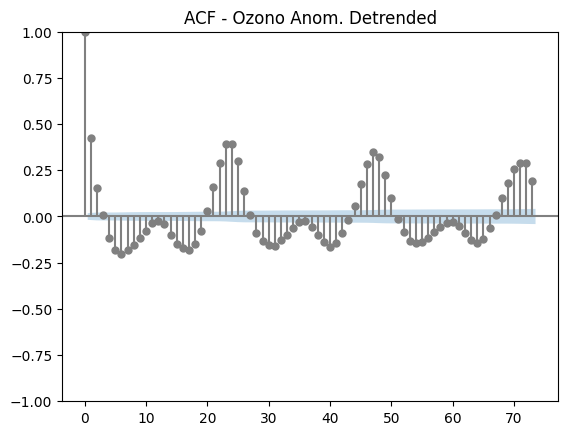

<Figure size 1200x600 with 0 Axes>

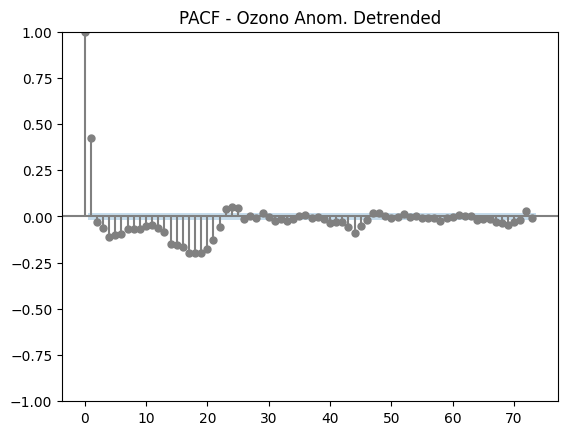


--- Prueba de Estacionariedad (ADF) para series detrended ---
Resultados ADF para PM2.5 Detrended:
ADF Statistic: -27.395171792591913
p-value: 0.0
Critical Values: {'1%': np.float64(-3.43091531991482), '5%': np.float64(-2.861789841507824), '10%': np.float64(-2.566902985547369)}
Conclusión: El p-value es menor que 0.05. Rechazamos la H0. La serie PM2.5 Detrended es estacionaria.
-----------------------------------------
Resultados ADF para Ozono Detrended:
ADF Statistic: -24.866857687241353
p-value: 0.0
Critical Values: {'1%': np.float64(-3.430915711158895), '5%': np.float64(-2.861790014400549), '10%': np.float64(-2.5669030775774995)}
Conclusión: El p-value es menor que 0.05. Rechazamos la H0. La serie Ozono Detrended es estacionaria.
-----------------------------------------


In [75]:
# Calculando anomalías para los modelo ARMA
pm25_anom = ss.zscore(pm25)
ozono_anom = ss.zscore(ozono)

# Eliminando la tendencia de las anomalías usando diferenciación
pm25_anom_detrended = np.diff(pm25_anom)
ozono_anom_detrended = np.diff(ozono_anom)

# Primeras anomalías detrended para verificar
print("Primeras 10 anomalías de PM2.5 sin tendencia:")
print(pm25_anom_detrended[:10])

print("\nPrimeras 10 anomalías de Ozono sin tendencia:")
print(ozono_anom_detrended[:10])

plt.figure(figsize=(12, 6))
plot_acf(pm25_anom_detrended, lags=73, title='ACF - PM 2.5 Anom. Detrended', color='black', vlines_kwargs={'colors': 'black'})
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(pm25_anom_detrended, lags=73, title='PACF - PM 2.5 Anom. Detrended', color='black', vlines_kwargs={'colors': 'black'})
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(ozono_anom_detrended, lags=73, title='ACF - Ozono Anom. Detrended', color='gray', vlines_kwargs={'colors': 'gray'})
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(ozono_anom_detrended, lags=73, title='PACF - Ozono Anom. Detrended', color='gray', vlines_kwargs={'colors': 'gray'})
plt.show()

# Prueba de estacionariedad para pm25_anom_detrended y ozono_anom_detrended
print("\n--- Prueba de Estacionariedad (ADF) para series detrended ---")

# Prueba ADF para pm25_anom_detrended
result_detrended_pm25 = adfuller(pm25_anom_detrended)
print("Resultados ADF para PM2.5 Detrended:")
print('ADF Statistic:', result_detrended_pm25[0])
print('p-value:', result_detrended_pm25[1])
print('Critical Values:', result_detrended_pm25[4])
if result_detrended_pm25[1] < 0.05:
  print("Conclusión: El p-value es menor que 0.05. Rechazamos la H0. La serie PM2.5 Detrended es estacionaria.")
else:
  print("Conclusión: El p-value es mayor o igual que 0.05. No rechazamos la H0. La serie PM2.5 Detrended no es estacionaria.")
print("-----------------------------------------")

# Prueba ADF para ozono_anom_detrended
result_detrended_ozono = adfuller(ozono_anom_detrended)
print("Resultados ADF para Ozono Detrended:")
print('ADF Statistic:', result_detrended_ozono[0])
print('p-value:', result_detrended_ozono[1])
print('Critical Values:', result_detrended_ozono[4])
if result_detrended_ozono[1] < 0.05:
  print("Conclusión: El p-value es menor que 0.05. Rechazamos la H0. La serie Ozono Detrended es estacionaria.")
else:
  print("Conclusión: El p-value es mayor o igual que 0.05. No rechazamos la H0. La serie Ozono Detrended no es estacionaria.")
print("-----------------------------------------")




In [76]:
#Modelo ARMA

arma_mod_pm25 = sm.tsa.ARIMA(pm25_anom_detrended, exog=None, order=(1, 0, 1))
model_fit_pm25 = arma_mod_pm25.fit()

arma_mod_ozono = sm.tsa.ARIMA(ozono_anom_detrended, exog=None, order=(1, 0, 1))
model_fit_ozono = arma_mod_ozono.fit()

In [77]:
#Resumen ARMA

print(model_fit_pm25.summary())
print("----------------------------------------------------------------------------")
print("----------------------------------------------------------------------------")
print("----------------------------------------------------------------------------")
print(model_fit_ozono.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                11603
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10955.693
Date:                Tue, 15 Jul 2025   AIC                          21919.387
Time:                        16:23:43   BIC                          21948.823
Sample:                             0   HQIC                         21929.278
                              - 11603                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.174e-05      0.001     -0.165      0.869      -0.001       0.001
ar.L1          0.6457      0.008     85.128      0.000       0.631       0.661
ma.L1         -0.9677      0.003   -352.590      0.0

In [78]:
#MSE y RMSE

ns_modfit_pm25 = model_fit_pm25.fittedvalues
mse_mod_pm25 = mean_squared_error(pm25_anom_detrended, ns_modfit_pm25)
rmse_mod_pm25 = mse_mod_pm25**0.5


ns_modfit_ozono = model_fit_ozono.fittedvalues
mse_mod_ozono = mean_squared_error(ozono_anom_detrended, ns_modfit_ozono)
rmse_mod_ozono = mse_mod_ozono**0.5

print("MSE para PM2.5:", mse_mod_pm25)
print("MSE para Ozono:", mse_mod_ozono)
print("-"*50)
print("RMSE para PM2.5:", rmse_mod_pm25)
print("RMSE para Ozono:", rmse_mod_ozono)


MSE para PM2.5: 0.3869429099572985
MSE para Ozono: 0.15250546102189483
--------------------------------------------------
RMSE para PM2.5: 0.6220473534686073
RMSE para Ozono: 0.39051947585478347


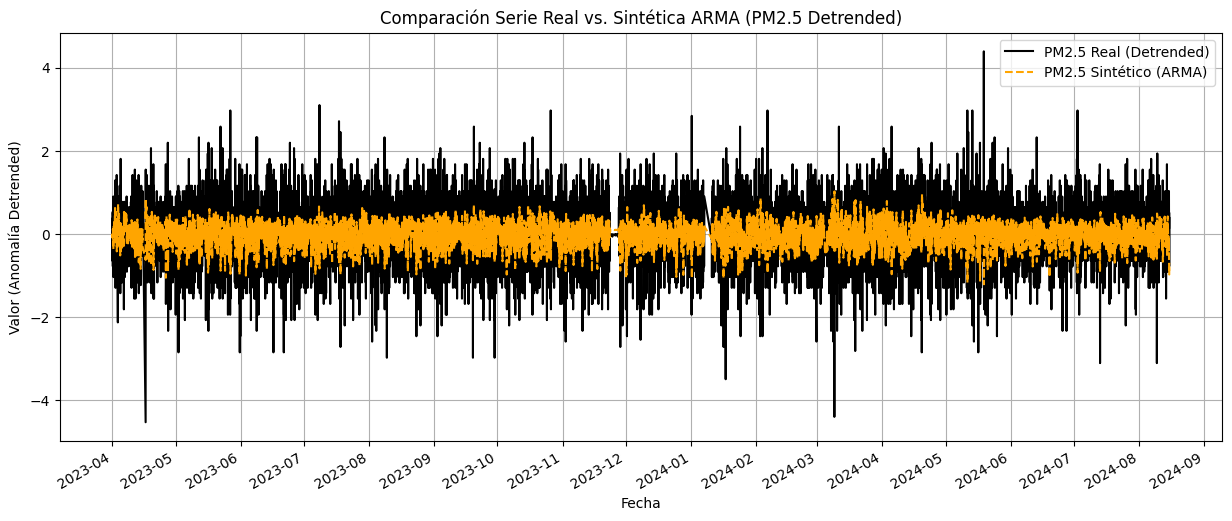

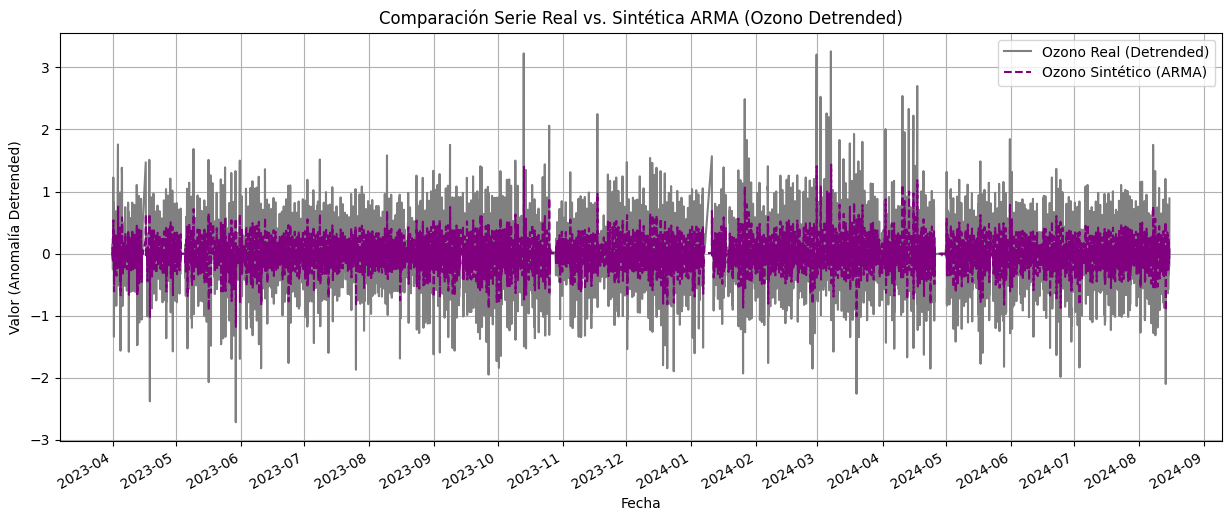

In [79]:
# Comparación serie sintética ARMA con la serie real (detrended)
plt.figure(figsize=(15, 6))
plt.plot(data_full_cleaned.index[1:], pm25_anom_detrended, label='PM2.5 Real (Detrended)', color='black')
plt.plot(data_full_cleaned.index[1:], ns_modfit_pm25, label='PM2.5 Sintético (ARMA)', color='orange', linestyle='--')
plt.title('Comparación Serie Real vs. Sintética ARMA (PM2.5 Detrended)')
plt.xlabel('Fecha')
plt.ylabel('Valor (Anomalía Detrended)')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(data_full_cleaned.index[1:], ozono_anom_detrended, label='Ozono Real (Detrended)', color='gray')
plt.plot(data_full_cleaned.index[1:], ns_modfit_ozono, label='Ozono Sintético (ARMA)', color='purple', linestyle='--')
plt.title('Comparación Serie Real vs. Sintética ARMA (Ozono Detrended)')
plt.xlabel('Fecha')
plt.ylabel('Valor (Anomalía Detrended)')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.show()


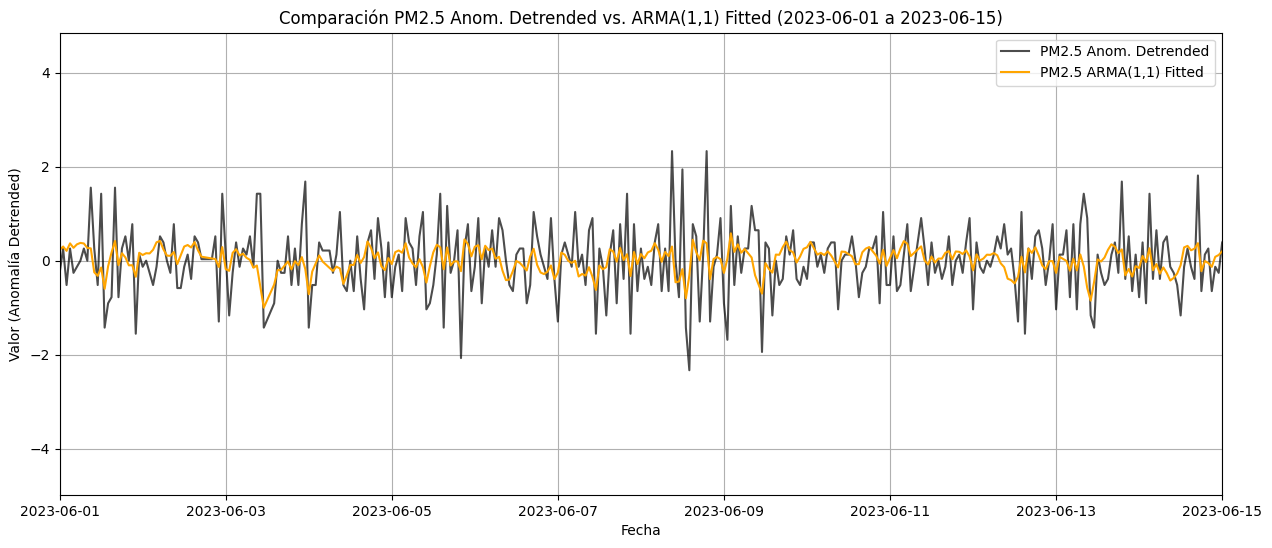

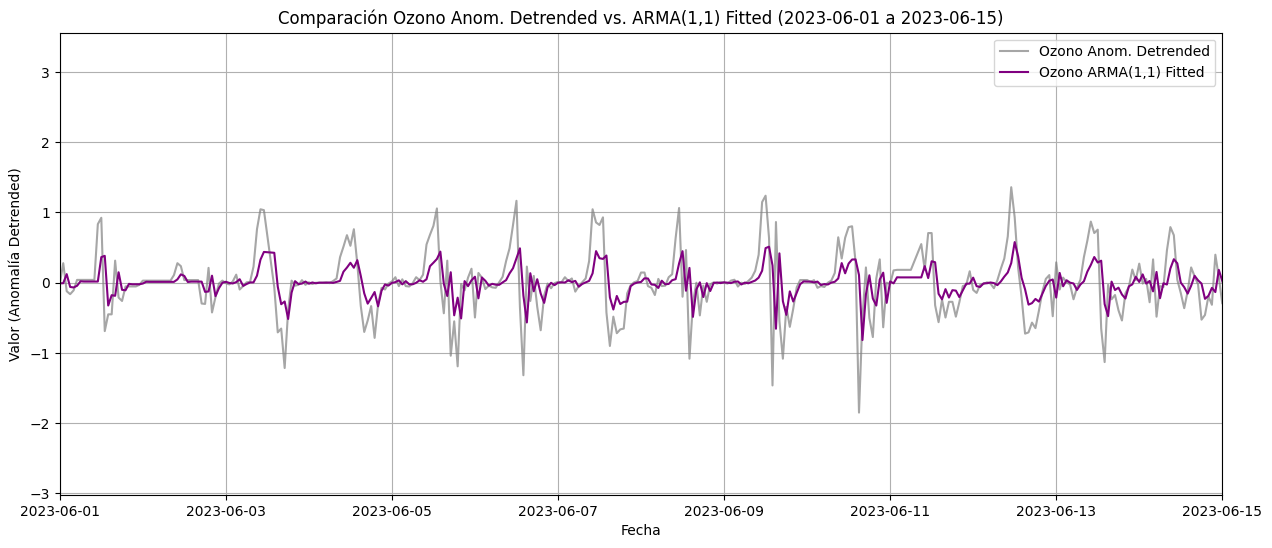

In [80]:
# Seleccion de un rango de fechas para visualizar la estacionalidad

start_date_str = '2023-06-01'
end_date_str = '2023-06-15' # Visualización de dos semanas


start_date = pd.to_datetime(start_date_str)
end_date = pd.to_datetime(end_date_str)

# Gráfica comparando Serie Real Anom. Detrended vs. Serie Sintética ARMA para PM2.5
plt.figure(figsize=(15, 6))

# Hacer coincidir posiciones
plt.plot(data_full_cleaned.index[1:], pm25_anom_detrended, label='PM2.5 Anom. Detrended', color='black', alpha=0.7) # alpha para transparencia
plt.plot(data_full_cleaned.index[1:], ns_modfit_pm25, label='PM2.5 ARMA(1,1) Fitted', color='orange')

plt.title(f'Comparación PM2.5 Anom. Detrended vs. ARMA(1,1) Fitted ({start_date_str} a {end_date_str})')
plt.xlabel('Fecha')
plt.ylabel('Valor (Anomalía Detrended)')

plt.xlim(start_date, end_date)
plt.grid(True)
plt.legend()
plt.show()


# Gráfica comparando Serie Real Anom. Detrended vs. Serie Sintética ARMA para Ozono
plt.figure(figsize=(15, 6))

plt.plot(data_full_cleaned.index[1:], ozono_anom_detrended, label='Ozono Anom. Detrended', color='gray', alpha=0.7) # alpha para transparencia
plt.plot(data_full_cleaned.index[1:], ns_modfit_ozono, label='Ozono ARMA(1,1) Fitted', color='purple')

plt.title(f'Comparación Ozono Anom. Detrended vs. ARMA(1,1) Fitted ({start_date_str} a {end_date_str})')
plt.xlabel('Fecha')
plt.ylabel('Valor (Anomalía Detrended)')

plt.xlim(start_date, end_date)
plt.grid(True)
plt.legend()
plt.show()

Diagnóstico de Residuales para PM2.5 ARMA(1,1)


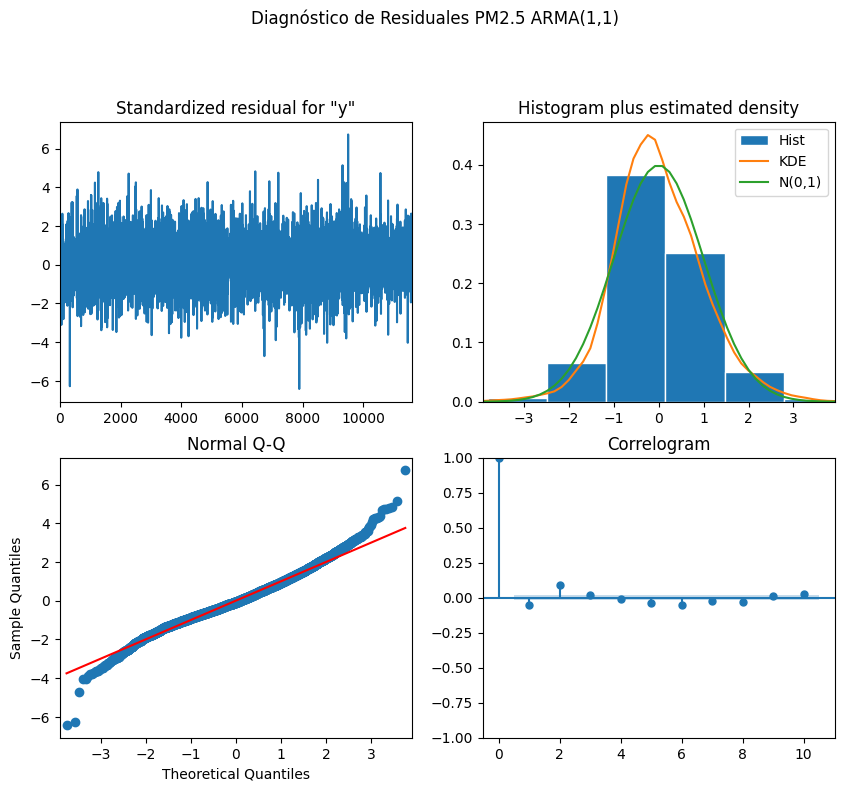


Diagnóstico de Residuales para Ozono ARMA(1,1)


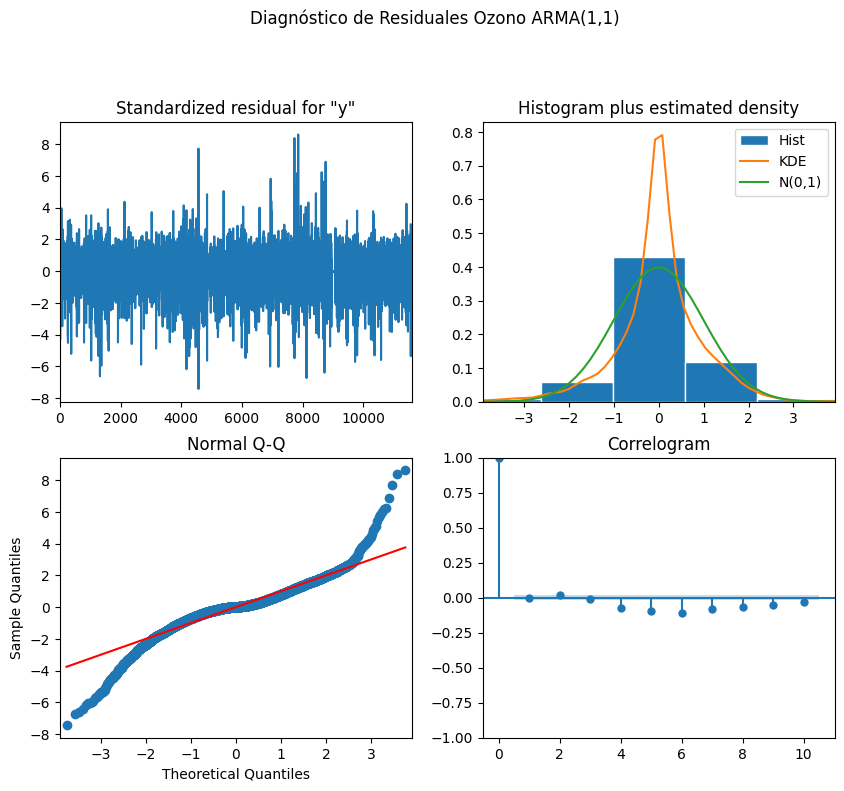

In [81]:
# Gráficos de diagnóstico para los residuales del modelo ARMA(1,1) de PM2.5
print("Diagnóstico de Residuales para PM2.5 ARMA(1,1)")
model_fit_pm25.plot_diagnostics(figsize=(10, 8))
plt.suptitle('Diagnóstico de Residuales PM2.5 ARMA(1,1)', y=1.02)
plt.show()

# Gráficos de diagnóstico para los residuales del modelo ARMA(1,1) de Ozono
print("\nDiagnóstico de Residuales para Ozono ARMA(1,1)")
model_fit_ozono.plot_diagnostics(figsize=(10, 8))
plt.suptitle('Diagnóstico de Residuales Ozono ARMA(1,1)', y=1.02)
plt.show()

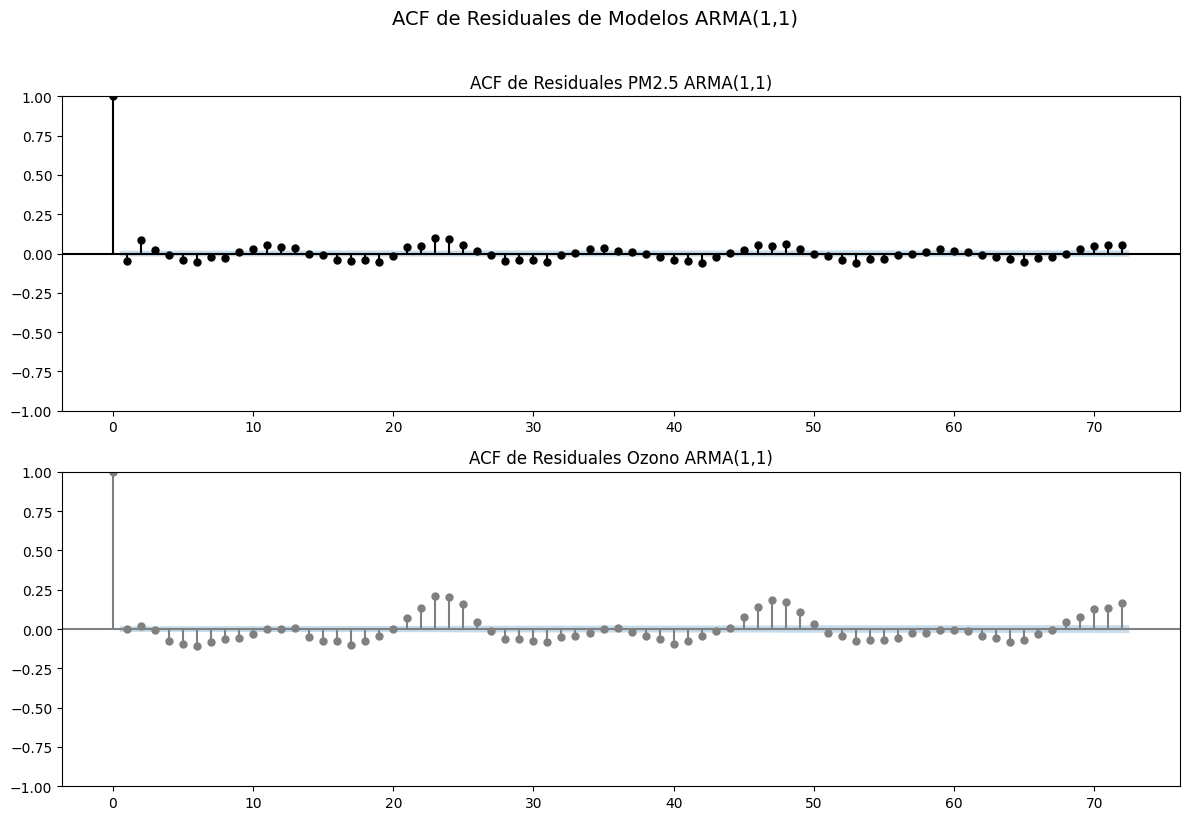

In [82]:
# Obtener los residuales de los modelos ajustados
residuals_pm25 = model_fit_pm25.resid
residuals_ozono = model_fit_ozono.resid

# Graficar ACF de los residuales con más rezagos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
fig.suptitle('ACF de Residuales de Modelos ARMA(1,1)', y=1.02, fontsize=14)

# ACF de Residuales PM2.5
plot_acf(residuals_pm25, lags=72, ax=axes[0], title='ACF de Residuales PM2.5 ARMA(1,1)', color='black', vlines_kwargs={'colors': 'black'})

# ACF de Residuales Ozono
plot_acf(residuals_ozono, lags=72, ax=axes[1], title='ACF de Residuales Ozono ARMA(1,1)', color='gray', vlines_kwargs={'colors': 'gray'})

plt.tight_layout()
plt.show()

In [83]:
# Utilizando la prueba de Kolmogorov-Smirnov para comparar las distribuciones
ks_statistic_pm25, p_value_pm25 = ks_2samp(ns_modfit_pm25, pm25_anom_detrended)

print("Prueba Kolmogorov-Smirnov para PM2.5:")
print("Estadístico KS:", ks_statistic_pm25)
print("Valor p:", p_value_pm25)

if (p_value_pm25 > 0.05):
    print("No se puede rechazar la hipótesis nula: las dos muestras provienen de la misma distribución.")
else:
    print("Se rechaza la hipótesis nula: las dos muestras no provienen de la misma distribución.")

print("-" * 50)

ks_statistic_ozono, p_value_ozono = ks_2samp(ns_modfit_ozono, ozono_anom_detrended)

print("Prueba Kolmogorov-Smirnov para Ozono:")
print("Estadístico KS:", ks_statistic_ozono)
print("Valor p:", p_value_ozono)

if (p_value_ozono > 0.05):
    print("No se puede rechazar la hipótesis nula: las dos muestras provienen de la misma distribución.")
else:
    print("Se rechaza la hipótesis nula: las dos muestras no provienen de la misma distribución.")

Prueba Kolmogorov-Smirnov para PM2.5:
Estadístico KS: 0.23640437817805748
Valor p: 9.783078618030675e-286
Se rechaza la hipótesis nula: las dos muestras no provienen de la misma distribución.
--------------------------------------------------
Prueba Kolmogorov-Smirnov para Ozono:
Estadístico KS: 0.13780918727915192
Valor p: 1.4076795201351148e-96
Se rechaza la hipótesis nula: las dos muestras no provienen de la misma distribución.


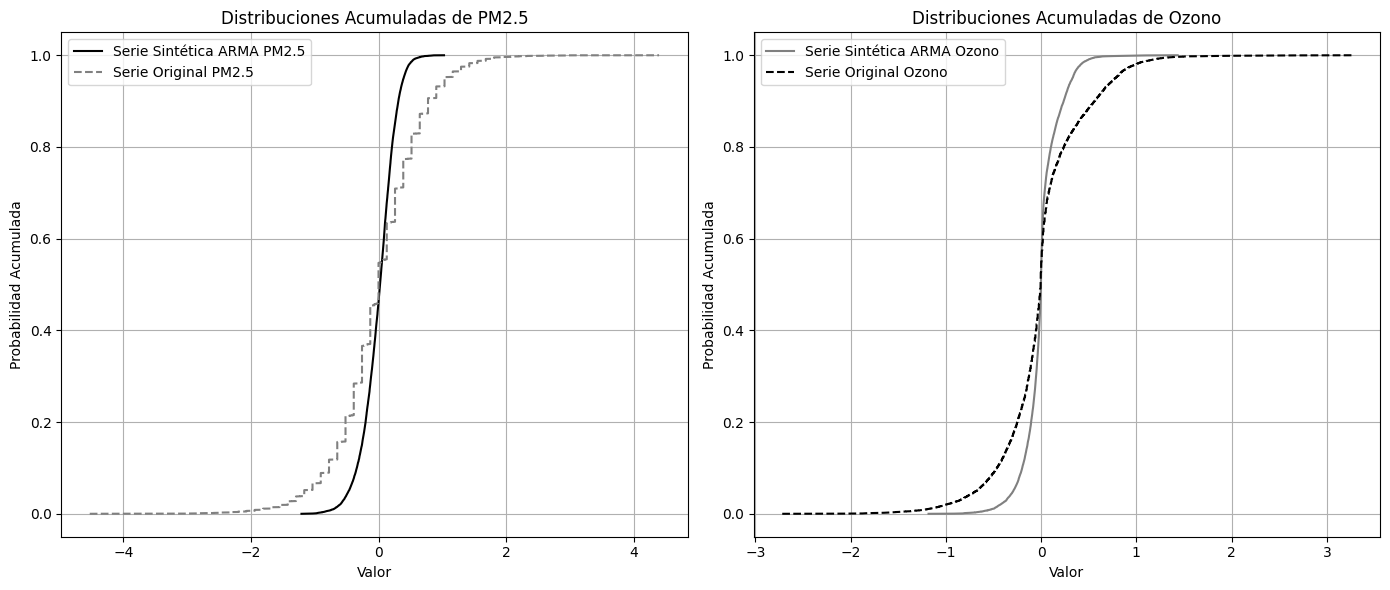

In [84]:
# Calcular las distribuciones acumuladas
sorted_ns_modfit_pm25 = np.sort(ns_modfit_pm25)
cdf_ns_modfit_pm25 = np.arange(1, len(sorted_ns_modfit_pm25)+1) / len(sorted_ns_modfit_pm25)

sorted_pm25 = np.sort(pm25_anom_detrended)
cdf_irregular_pm25 = np.arange(1, len(sorted_pm25)+1) / len(sorted_pm25)

sorted_ns_modfit_ozono = np.sort(ns_modfit_ozono)
cdf_ns_modfit_ozono = np.arange(1, len(sorted_ns_modfit_ozono)+1) / len(sorted_ns_modfit_ozono)

sorted_ozono = np.sort(ozono_anom_detrended)
cdf_irregular_ozono = np.arange(1, len(sorted_ozono)+1) / len(sorted_ozono)

# Crear la figura y los ejes para las dos gráficas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Gráfica para PM2.5
axes[0].plot(sorted_ns_modfit_pm25, cdf_ns_modfit_pm25, label='Serie Sintética ARMA PM2.5', color='black')
axes[0].plot(sorted_pm25, cdf_irregular_pm25, label='Serie Original PM2.5', color='gray', linestyle='--')
axes[0].set_title('Distribuciones Acumuladas de PM2.5')
axes[0].set_xlabel('Valor')
axes[0].set_ylabel('Probabilidad Acumulada')
axes[0].legend()
axes[0].grid(True)

# Gráfica para Ozono
axes[1].plot(sorted_ns_modfit_ozono, cdf_ns_modfit_ozono, label='Serie Sintética ARMA Ozono', color='gray')
axes[1].plot(sorted_ozono, cdf_irregular_ozono, label='Serie Original Ozono', color='black', linestyle='--')
axes[1].set_title('Distribuciones Acumuladas de Ozono')
axes[1].set_xlabel('Valor')
axes[1].set_ylabel('Probabilidad Acumulada')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [85]:
# Empezar a analizar correlaciones

# Realizar la prueba de correlación de Pearson
correlation_coefficient, p_value = ss.pearsonr(pm25_anom_detrended, ozono_anom_detrended)

print("Coeficiente de Correlación de Pearson:", correlation_coefficient)
print("Valor p:", p_value)
print("-" * 50)

# Interpretar el valor p para la correlación de Pearson
alpha = 0.05
if (p_value > alpha):
    print(f"No se puede rechazar la hipótesis nula (al nivel de significancia {alpha}): No hay evidencia de una correlación lineal estadísticamente significativa entre PM2.5 y Ozono.")
else:
    print(f"Se rechaza la hipótesis nula (al nivel de significancia {alpha}): Existe una correlación lineal estadísticamente significativa entre PM2.5 y Ozono.")

Coeficiente de Correlación de Pearson: -0.0656333278585584
Valor p: 1.47618170621936e-12
--------------------------------------------------
Se rechaza la hipótesis nula (al nivel de significancia 0.05): Existe una correlación lineal estadísticamente significativa entre PM2.5 y Ozono.


Text(0, 0.5, 'Ozono')

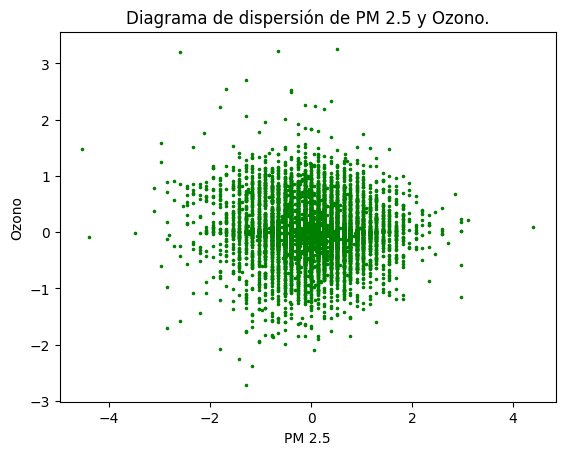

In [86]:
# Diagrama de dispersión entre los valores

plt.scatter(pm25_anom_detrended, ozono_anom_detrended, color='green', s=2.5)
plt.title("Diagrama de dispersión de PM 2.5 y Ozono.")
plt.xlabel("PM 2.5")
plt.ylabel("Ozono")

In [87]:
# Regresión lineal simple

# ajustamos el modelo: la función "ols" hace un ajuste por mínimos cuadrado... ¿qué signinfica eso?
model = sm.OLS(ozono_anom_detrended, pm25_anom_detrended)
results = model.fit()

# obtiene la nueva variable "Y", es decir, la predicción de "Y" hecha a partir de la regresión lineal...
y_pred1 = results.predict(pm25_anom_detrended)

# obtiene los residuales
resid1 = results.resid

# resumen resultado de la regresión. de interés: valor-P, R2, prueba DW, prueba JB (residuales), prueba F...
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              50.19
Date:                Tue, 15 Jul 2025   Prob (F-statistic):                    1.47e-12
Time:                        16:23:47   Log-Likelihood:                         -6699.3
No. Observations:               11603   AIC:                                  1.340e+04
Df Residuals:                   11602   BIC:                                  1.341e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [88]:
# Ajustar un modelo de regresión lineal simple con intercepto
# Usamos sm.add_constant para añadir una columna de unos que representa el intercepto
X = sm.add_constant(pm25_anom_detrended)
Y = ozono_anom_detrended

# Ajustamos el modelo OLS (Minimos Cuadrados Ordinarios)
model_with_intercept = sm.OLS(Y, X)
results_with_intercept = model_with_intercept.fit()

# Imprimir el resumen de los resultados
print(results_with_intercept.summary())

# Opcional: Obtener predicciones y residuales del modelo con intercepto
y_pred_with_intercept = results_with_intercept.predict(X)
resid_with_intercept = results_with_intercept.resid

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     50.19
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           1.48e-12
Time:                        16:23:47   Log-Likelihood:                -6699.3
No. Observations:               11603   AIC:                         1.340e+04
Df Residuals:                   11601   BIC:                         1.342e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        8.82e-05      0.004      0.022      0.9

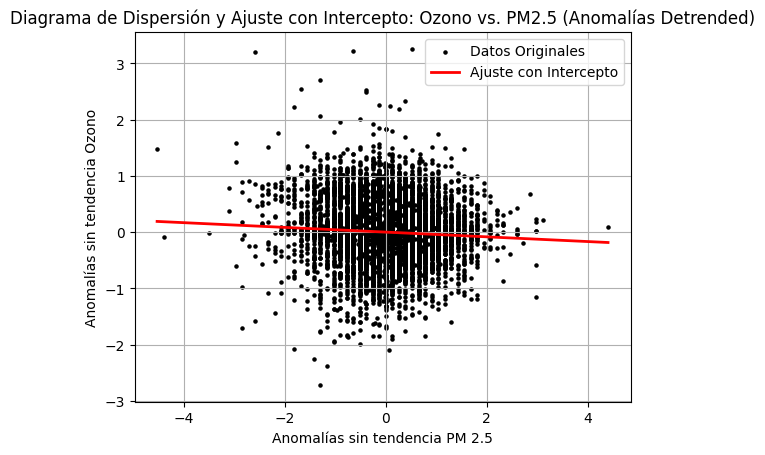

In [89]:
# Crear el diagrama de dispersión
plt.scatter(pm25_anom_detrended, ozono_anom_detrended, color='black', s=5, label='Datos Originales')

sorted_indices = np.argsort(pm25_anom_detrended)
sorted_pm25_anom_detrended = pm25_anom_detrended[sorted_indices]
sorted_y_pred_with_intercept = y_pred_with_intercept[sorted_indices]

plt.plot(sorted_pm25_anom_detrended, sorted_y_pred_with_intercept, color='red', linewidth=2, label='Ajuste con Intercepto')

plt.title("Diagrama de Dispersión y Ajuste con Intercepto: Ozono vs. PM2.5 (Anomalías Detrended)")
plt.xlabel("Anomalías sin tendencia PM 2.5")
plt.ylabel("Anomalías sin tendencia Ozono")

plt.legend()
plt.grid(True)
plt.show()

In [90]:
# Ajuste polinomial (cuadrático)
ord_polin = 2

model_sq = np.polyfit(pm25_anom_detrended, ozono_anom_detrended, ord_polin)
print("parámetros modelo:")
print(model_sq)

func_pol = np.poly1d(model_sq)
print("función cuadrática (polinómica):")
print(func_pol)

# obtiene la nueva variable "Y", es decir, la predicción de "Y" hecha a partir de la regresión cuadrática...
# Usar la serie pm25 original detrended para predecir con el modelo polinomial
y_pred2 = np.polyval(model_sq, pm25_anom_detrended)
resid2 = ozono_anom_detrended - y_pred2 # Calcular residuales: Y real - Y predicha

# obtener la nueva variable "Y" usando la función polinómica y comparar con "y_pred2"

# Para calcular R², se necesita importar r2_score
from sklearn.metrics import r2_score
r2_y_pred2 = r2_score(ozono_anom_detrended, y_pred2) # Y real, Y predicha
print(f"El valor de R² para el ajuste polinomial (orden {ord_polin}) es: {r2_y_pred2:.3f}")

# resid2 = Y - y_pred2 # Residuales ya calculados arriba

parámetros modelo:
[ 0.03011458 -0.03936821 -0.01363297]
función cuadrática (polinómica):
         2
0.03011 x - 0.03937 x - 0.01363
El valor de R² para el ajuste polinomial (orden 2) es: 0.008


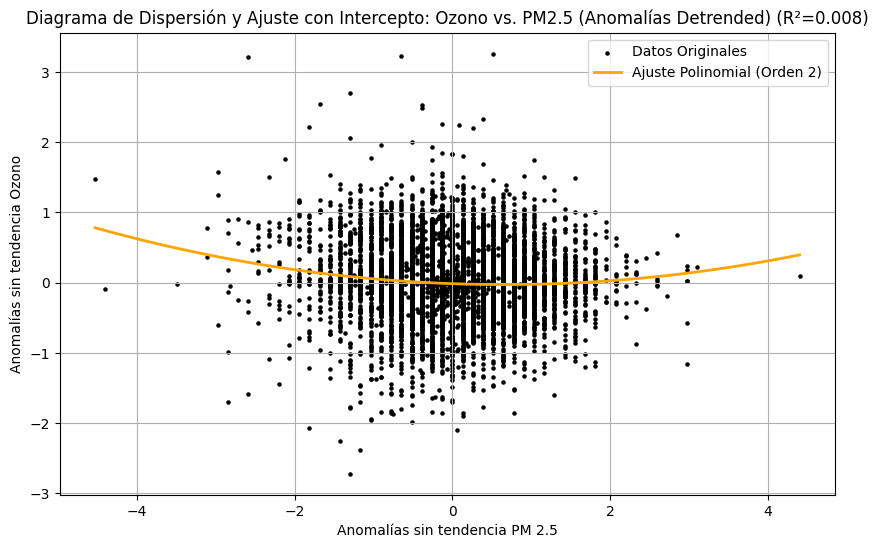

In [91]:
# Gráfico del ajuste cuadrático
plt.figure(figsize=(10, 6))

# Diagrama de dispersión de los datos originales
plt.scatter(pm25_anom_detrended, ozono_anom_detrended, color='black', s=5, label='Datos Originales')

x_fit = np.linspace(pm25_anom_detrended.min(), pm25_anom_detrended.max(), 100) # Crea 100 puntos entre el min y max de pm25
y_fit = func_pol(x_fit) # Calcula los valores Y predichos para estos puntos X

plt.plot(x_fit, y_fit, color='orange', linewidth=2, label=f'Ajuste Polinomial (Orden {ord_polin})')

plt.title(f"Diagrama de Dispersión y Ajuste con Intercepto: Ozono vs. PM2.5 (Anomalías Detrended) (R²={r2_y_pred2:.3f})")
plt.xlabel("Anomalías sin tendencia PM 2.5")
plt.ylabel("Anomalías sin tendencia Ozono")

plt.legend()
plt.grid(True)
plt.show()

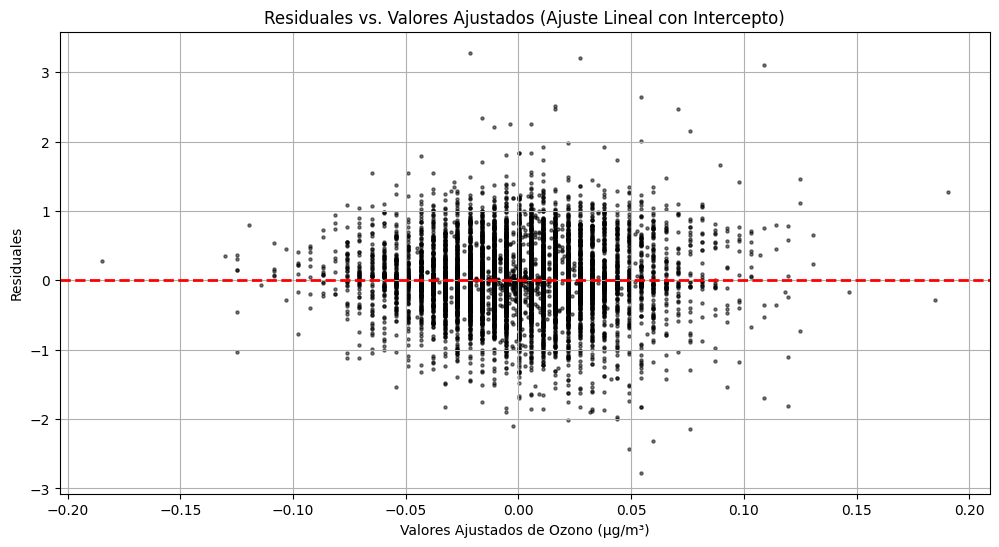

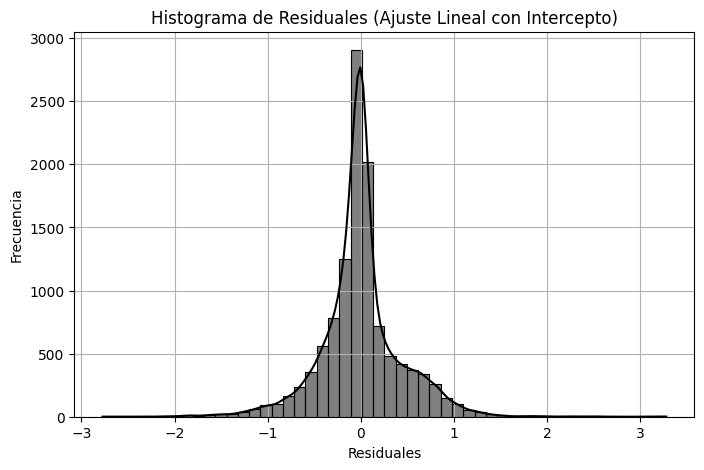

/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


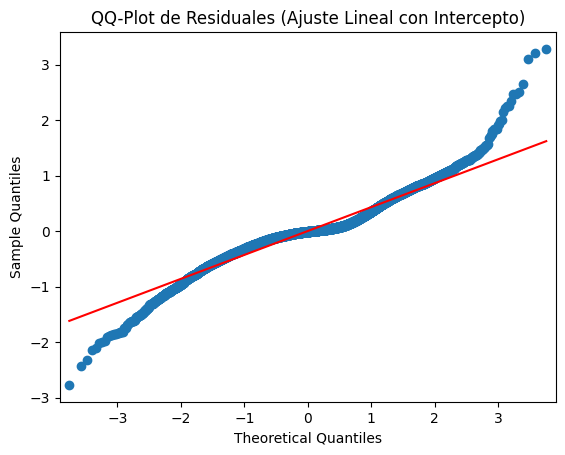

<Figure size 1000x400 with 0 Axes>

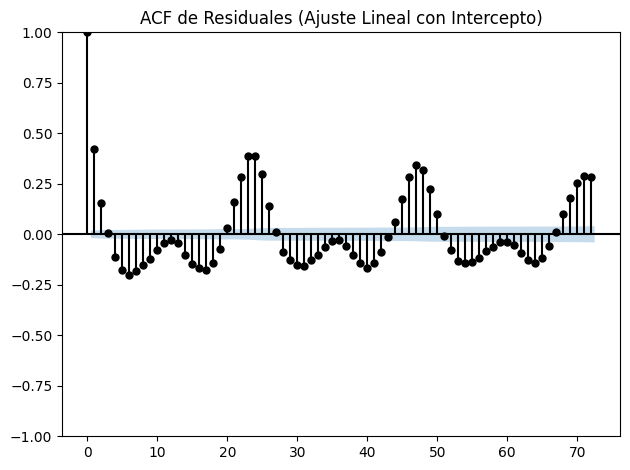

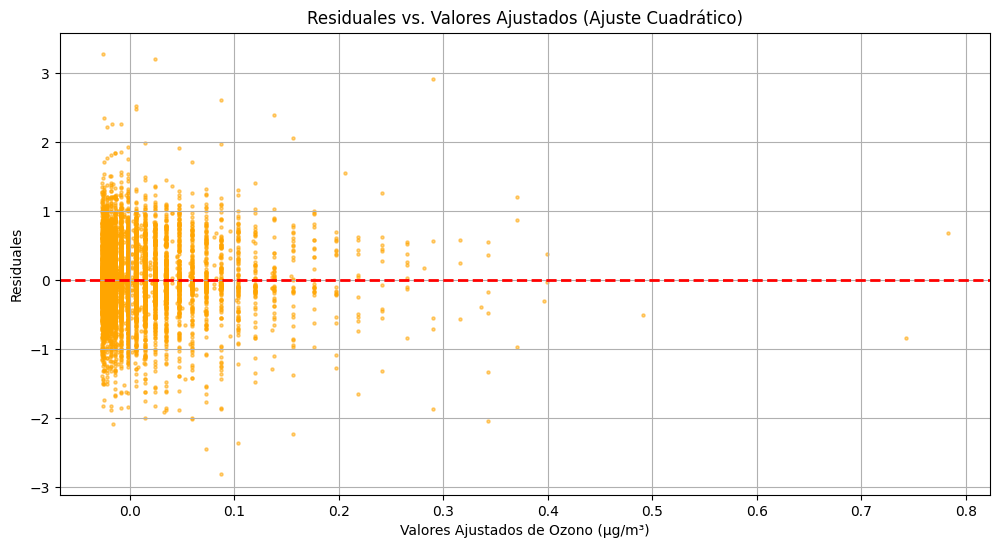

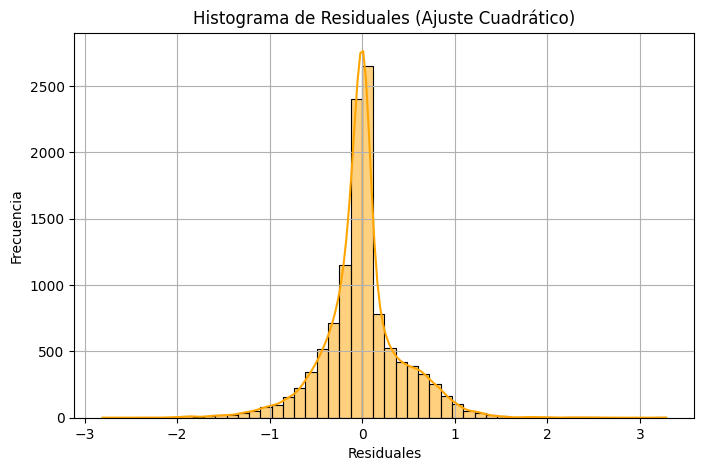

/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


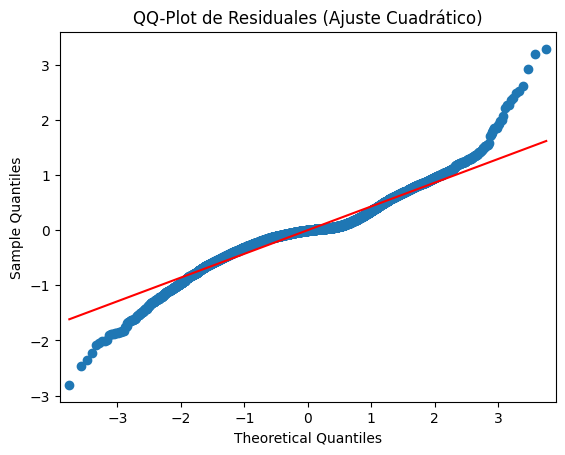

<Figure size 1000x400 with 0 Axes>

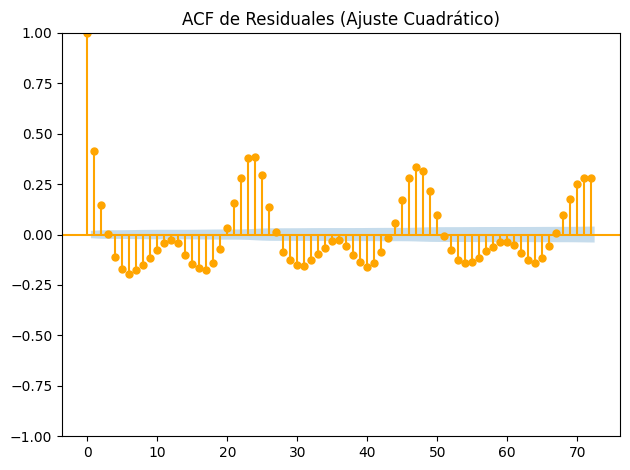

In [92]:


# Análisis de Residuales para Ajuste Lineal y Cuadrático

# 1. Análisis de Residuales para el Ajuste Lineal
# Residuales del ajuste lineal con intercepto ya calculados como `resid_with_intercept`

plt.figure(figsize=(12, 6))
plt.scatter(y_pred_with_intercept, resid_with_intercept, color='black', s=5, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2) # Línea horizontal en 0
plt.title('Residuales vs. Valores Ajustados (Ajuste Lineal con Intercepto)')
plt.xlabel('Valores Ajustados de Ozono (μg/m³)')
plt.ylabel('Residuales')
plt.grid(True)
plt.show()

# Histograma de los residuales del ajuste lineal
plt.figure(figsize=(8, 5))
sns.histplot(resid_with_intercept, kde=True, color='black', bins=50)
plt.title('Histograma de Residuales (Ajuste Lineal con Intercepto)')
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# QQ-Plot de los residuales del ajuste lineal
sm.qqplot(resid_with_intercept, line='s', color='black') # line='s' plots a 45-degree line
plt.title('QQ-Plot de Residuales (Ajuste Lineal con Intercepto)')
plt.show()

# Autocorrelograma (ACF) de los residuales del ajuste lineal
plt.figure(figsize=(10, 4))
plot_acf(resid_with_intercept, lags=72, title='ACF de Residuales (Ajuste Lineal con Intercepto)', color='black', vlines_kwargs={'colors': 'black'})
plt.tight_layout()
plt.show()


# 2. Análisis de Residuales para el Ajuste Cuadrático
# Residuales del ajuste cuadrático ya calculados como `resid2`

plt.figure(figsize=(12, 6))
# Usamos los valores predichos del modelo cuadrático en el eje X
plt.scatter(y_pred2, resid2, color='orange', s=5, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2) # Línea horizontal en 0
plt.title('Residuales vs. Valores Ajustados (Ajuste Cuadrático)')
plt.xlabel('Valores Ajustados de Ozono (μg/m³)')
plt.ylabel('Residuales')
plt.grid(True)
plt.show()

# Histograma de los residuales del ajuste cuadrático
plt.figure(figsize=(8, 5))
sns.histplot(resid2, kde=True, color='orange', bins=50)
plt.title('Histograma de Residuales (Ajuste Cuadrático)')
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# QQ-Plot de los residuales del ajuste cuadrático
sm.qqplot(resid2, line='s', color='orange') # line='s' plots a 45-degree line
plt.title('QQ-Plot de Residuales (Ajuste Cuadrático)')
plt.show()

# Autocorrelograma (ACF) de los residuales del ajuste cuadrático
plt.figure(figsize=(10, 4))
plot_acf(resid2, lags=72, title='ACF de Residuales (Ajuste Cuadrático)', color='orange', vlines_kwargs={'colors': 'orange'})
plt.tight_layout()
plt.show()

